#   Alberto Sartini's Master's Thesis - Stock Market Forecasting

# Random walk synthetic data for diagnostic

# Packages Loading

In [53]:
#EDA Libraries
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np
from tabulate import tabulate


#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from pandas.plotting import register_matplotlib_converters

In [54]:
#Statistical Libraries
import statsmodels.stats.api as sms
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr
from scipy.stats import kurtosis, skew
from scipy.stats import ttest_rel
import itertools

In [55]:
# Sci-kit learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error , mean_absolute_percentage_error
# Parameter Grid
from sklearn.model_selection import ParameterGrid
# Random Forest
from sklearn.ensemble import RandomForestRegressor


In [56]:
#Reti Neurali

from tensorflow.python.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from keras import layers, models
import random
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [57]:
# High-frequency synthetic data
import time
from scipy.interpolate import interp1d
from arch import arch_model
import pandas_market_calendars as mcal

# Pre-Processing and EDA

In [58]:

# Parametri
n_obs = 28855
start_date = "1944-12-31"

np.random.seed(42)

# Simulazione dei log-rendimenti giornalieri
r_sp500 = np.random.normal(loc=0, scale=0.01, size=n_obs)       # ≈ 1% volatilità giornaliera
r_earnings = np.random.normal(loc=0, scale=0.005, size=n_obs)
r_10y = np.random.normal(loc=0, scale=0.002, size=n_obs)

# Calcolo dei log-prezzi cumulati
l_sp500 = np.log(13) + np.cumsum(r_sp500)
l_earnings = np.log(0.93) + np.cumsum(r_earnings)
l_rate_10y = np.log(2.4) + np.cumsum(r_10y)

# Ritorno ai livelli (prezzi)
sp500 = np.exp(l_sp500)
earnings = np.exp(l_earnings)
rate_10y = np.exp(l_rate_10y)

# Creazione del DataFrame
dates = pd.date_range(start=start_date, periods=n_obs, freq='B')
df = pd.DataFrame({
    "date": dates,
    "sp_500": sp500,
    "earnings": earnings,
    "10y_usa_rate": rate_10y
}).set_index("date")

print(df.head())


               sp_500  earnings  10y_usa_rate
date                                         
1945-01-01  13.064733  0.930026      2.402488
1945-01-02  13.046682  0.932169      2.406027
1945-01-03  13.131458  0.929482      2.409521
1945-01-04  13.332985  0.926855      2.414031
1945-01-05  13.301802  0.928754      2.411289


In [59]:
df

,sp_500,earnings,10y_usa_rate
date,,,
1945-01-01,13.064733,0.930026,2.402488
1945-01-02,13.046682,0.932169,2.406027
1945-01-03,13.131458,0.929482,2.409521
1945-01-04,13.332985,0.926855,2.414031
1945-01-05,13.301802,0.928754,2.411289
...,...,...,...
2055-08-02,13.235057,0.655087,3.620963
2055-08-03,13.160269,0.653462,3.620384
2055-08-04,13.371295,0.652492,3.625928


In [60]:
df.isnull().any()

sp_500          False
earnings        False
10y_usa_rate    False
dtype: bool

In [61]:
df.describe()

,sp_500,earnings,10y_usa_rate
count,28855.000000,28855.000000,28855.000000
mean,19.753858,0.770189,3.247556
std,9.306747,0.166525,0.312349
min,5.894324,0.349210,2.398302
25%,11.666403,0.674129,3.095914
50%,18.425739,0.794522,3.294848
75%,27.814612,0.882337,3.472620
max,46.930314,1.152866,3.894363


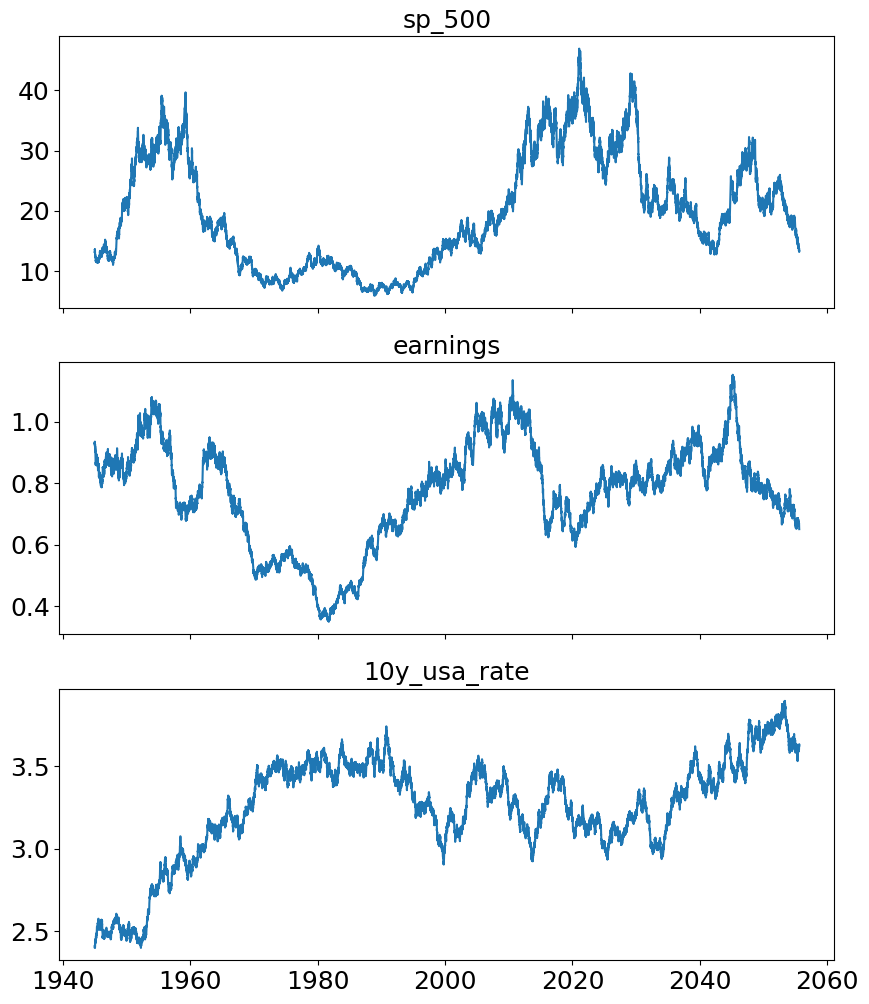

In [62]:
# Plot of the time series in nominal value

num_vars = len(df.columns)
fig, axes = plt.subplots(num_vars, 1, figsize=(10, 4 * num_vars), sharex=True)

for i, col in enumerate(df.columns):
    axes[i].plot(df.index, df[col])
    
    # Imposta titolo e dimensione dei caratteri
    axes[i].set_title(df[col].name, fontsize=18)
    axes[i].tick_params(axis='both', labelsize=18)  # Dimensione dei caratteri degli assi
    axes[i].grid(False)
#plt.savefig('grafici/serie_in_valore_nominale.svg', format='svg')
plt.show()


In [63]:
# ADF test to check the stationarity of the time series in nominal value

for i, col in enumerate(df.columns):
    adf_result = adfuller(df[col])
    adf_statistic = adf_result[0]
    p_value = adf_result[1]
    used_lags = adf_result[2]
    nobs = adf_result[3]
    critical_values = adf_result[4]
    icbest = adf_result[5]
    
    
    print(f'Results of ADF Test on Residuals for {col}:')
    print(f'ADF Statistic for {col}: {adf_statistic}')
    print(f'p-value for {col} : {p_value}')
    print(f'Number of lags used for {col} : {used_lags}')
    print(f'Number of observations used for {col} : {nobs}')
    print('')
    
# All three series are found to be non-stationary

Results of ADF Test on Residuals for sp_500:
ADF Statistic for sp_500: -1.9970683074757567
p-value for sp_500 : 0.2878600218113778
Number of lags used for sp_500 : 0
Number of observations used for sp_500 : 28854

Results of ADF Test on Residuals for earnings:
ADF Statistic for earnings: -2.0706748433777564
p-value for earnings : 0.2564686739265507
Number of lags used for earnings : 0
Number of observations used for earnings : 28854

Results of ADF Test on Residuals for 10y_usa_rate:
ADF Statistic for 10y_usa_rate: -2.6022059682494856
p-value for 10y_usa_rate : 0.09254219526208868
Number of lags used for 10y_usa_rate : 0
Number of observations used for 10y_usa_rate : 28854



In [64]:
# Transformation of the dataset into log-levels
df_log = np.log(df)
df_log.columns = ['l_' + col for col in df.columns]

In [65]:
df_log

,l_sp_500,l_earnings,l_10y_usa_rate
date,,,
1945-01-01,2.569916,-0.072543,0.876505
1945-01-02,2.568534,-0.070241,0.877977
1945-01-03,2.575011,-0.073127,0.879428
1945-01-04,2.590241,-0.075958,0.881298
1945-01-05,2.587900,-0.073911,0.880161
...,...,...,...
2055-08-02,2.582869,-0.422988,1.286740
2055-08-03,2.577202,-0.425471,1.286580
2055-08-04,2.593110,-0.426957,1.288110


In [66]:
df_log.isnull().any()

l_sp_500          False
l_earnings        False
l_10y_usa_rate    False
dtype: bool

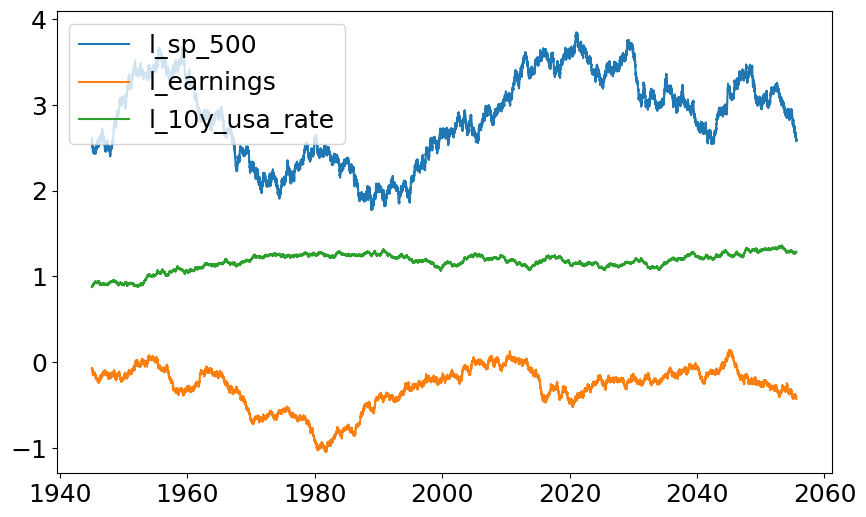

In [67]:
# Plot representing all three series in log-levels

plt.figure(figsize=(10, 6))

for column in df_log.columns:
    plt.plot(df_log.index, df_log[column], label=column)

plt.legend(fontsize=18)
plt.xticks(fontsize=18)  
plt.yticks(fontsize=18)  
plt.grid(False)
#plt.savefig('grafici/serie_in_log-livelli.svg', format='svg')
plt.show()


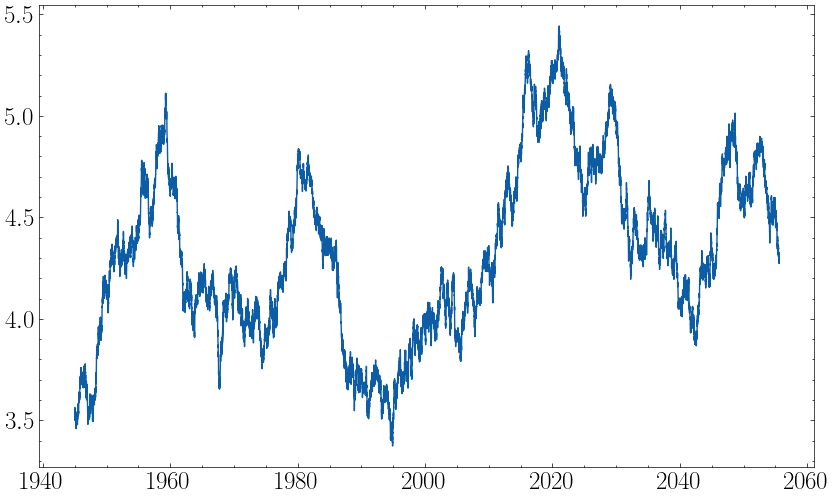

In [68]:
# Plot related to the Ziemba et al. indicator "I"

i_df = df_log['l_10y_usa_rate']-df_log['l_earnings']+df_log['l_sp_500']

with plt.style.context('science'):
    plt.figure(figsize=(10, 6))
    plt.plot(df_log.index,i_df, label='I')
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)
    plt.grid(False)
    #plt.savefig('grafici/logarithmic_indicator.svg', format='svg')

    plt.show()

In [69]:
i_df =i_df.to_frame(name='indicator')
i_df.head()

,indicator
date,
1945-01-01,3.518964
1945-01-02,3.516752
1945-01-03,3.527566
1945-01-04,3.547497
1945-01-05,3.541972


In [70]:
# ADF test for "I"

adf_result = adfuller(i_df['indicator'])
adf_statistic = adf_result[0]
p_value = adf_result[1]
used_lags = adf_result[2]
nobs = adf_result[3]
critical_values = adf_result[4]
icbest = adf_result[5]

print(f'Results of ADF Test on Residuals for indicator:')
print(f'ADF Statistic for indicator: {adf_statistic}')
print(f'p-value for indicator: {p_value}')
print(f'Number of lags used for indicator: {used_lags}')
print(f'Number of observations used for indicator: {nobs}')


Results of ADF Test on Residuals for indicator:
ADF Statistic for indicator: -2.648844338842318
p-value for indicator: 0.08331637390834151
Number of lags used for indicator: 0
Number of observations used for indicator: 28854


## Selecting only the trading days

In [38]:
def get_trading_days(df_daily): 
    
    nyse = mcal.get_calendar('NYSE')
    trading_days = nyse.valid_days(start_date=df_daily.index[0], 
                                end_date=df_daily.index[-1])
    trading_days = pd.DatetimeIndex(trading_days)
    trading_days = trading_days.tz_localize(None)

    df_traiding_days = df_daily.loc[df_daily.index.isin(trading_days)]

    return df_traiding_days

In [39]:
df_synthetic_log_levels

,sp_500,earnings,10y_usa_rate
1944-12-31,2.590027,-0.062368,0.887903
1945-01-01,2.568711,-0.075066,0.860738
1945-01-02,2.597213,-0.058576,0.894083
1945-01-03,2.628849,-0.040251,0.931234
1945-01-04,2.568188,-0.076000,0.856281
...,...,...,...
2023-12-27,8.439792,5.254382,1.398561
2023-12-28,8.427502,5.246711,1.378066
2023-12-29,8.504731,5.291489,1.466302
2023-12-30,8.451836,5.260029,1.396489


In [40]:
df_synthetic_log_levels_trading_days_only = get_trading_days(df_synthetic_log_levels)
df_synthetic_log_levels_trading_days_only

,sp_500,earnings,10y_usa_rate
1945-01-02,2.597213,-0.058576,0.894083
1945-01-03,2.628849,-0.040251,0.931234
1945-01-04,2.568188,-0.076000,0.856281
1945-01-05,2.569135,-0.075655,0.856157
1945-01-06,2.633658,-0.038061,0.933253
...,...,...,...
2023-12-22,8.389217,5.227099,1.364966
2023-12-26,8.446800,5.258957,1.412639
2023-12-27,8.439792,5.254382,1.398561
2023-12-28,8.427502,5.246711,1.378066


In [41]:
df_synthetic_levels_trading_days_only = get_trading_days(df_synthetic_levels)
df_synthetic_levels_trading_days_only

,sp_500,earnings,10y_usa_rate
1945-01-02,13.426269,0.943106,2.445092
1945-01-03,13.857814,0.960549,2.537639
1945-01-04,13.042171,0.926816,2.354388
1945-01-05,13.054527,0.927136,2.354097
1945-01-06,13.924614,0.962654,2.542767
...,...,...,...
2023-12-22,4399.370325,186.251719,3.915589
2023-12-26,4660.135921,192.280869,4.106780
2023-12-27,4627.593001,191.403097,4.049368
2023-12-28,4571.065802,189.940543,3.967222


## df_synthetic_filtered saving

In [42]:
"""""
df_synthetic_log_levels_trading_days_only.to_csv('df_synthetic_log_levels_trading_days_only.csv', index=True)
df_synthetic_levels_trading_days_only.to_csv('df_synthetic_levels_trading_days_only.csv', index=True)
"""""

'""\ndf_synthetic_log_levels_trading_days_only.to_csv(\'df_synthetic_log_levels_trading_days_only.csv\', index=True)\ndf_synthetic_levels_trading_days_only.to_csv(\'df_synthetic_levels_trading_days_only.csv\', index=True)\n'

In [43]:
df_synthetic_log_levels_trading_days_only = pd.read_csv('df_synthetic_log_levels_trading_days_only.csv', index_col=0, parse_dates=True)
df_synthetic_levels_trading_days_only = pd.read_csv('df_synthetic_levels_trading_days_only.csv', index_col=0, parse_dates=True)

In [44]:
df_synthetic_levels_trading_days_only

,sp_500,earnings,10y_usa_rate
1945-01-02,13.426269,0.943106,2.445092
1945-01-03,13.857814,0.960549,2.537639
1945-01-04,13.042171,0.926816,2.354388
1945-01-05,13.054527,0.927136,2.354097
1945-01-06,13.924614,0.962654,2.542767
...,...,...,...
2023-12-22,4399.370325,186.251719,3.915589
2023-12-26,4660.135921,192.280869,4.106780
2023-12-27,4627.593001,191.403097,4.049368
2023-12-28,4571.065802,189.940543,3.967222


# Functions Definition

## ADF Test Function


In [45]:
def adf_test(residuals_step1):
    
    result = adfuller(residuals_step1)
    return{
        'ADF Statistic:': result[0],
        'p-value:': result[1],
        'Critical Values:':result[4]}

## VAR Lag Selection Function


In [46]:
def var_lag_selection(l_px):
    
    # Creation of the VAR model
    model = VAR(l_px)

    # Using the 'select_order' function to determine the optimal lag
    lag_order = model.select_order(maxlags=15)

    # Find the optimal lag for each criterion
    aic_lag = lag_order.aic
    bic_lag = lag_order.bic
    hqic_lag = lag_order.hqic
    fpe_lag = lag_order.fpe

    # Trova il minimo tra questi lag
    min_lag = min(aic_lag, bic_lag, hqic_lag, fpe_lag)

    return min_lag

## Residual Normality Function (Jarque-Bera Test)

In [47]:
def jb_test(residuals):
    
    result=sms.jarque_bera(residuals)
    return {
        'jb statistic:': result[0],
        'p-value:': result[1],
        'skew:':result[2],
        'kurtosis:':result[3]}

## Series to Lagged Function

In [48]:
def series_to_lagged(d_l_px, lag_ecm, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		d_l_px: Sequence of observations as a dataframe.
		lag_ecm: Number of lags.
		
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""	
	n_vars=d_l_px.shape[1] # number of variables
	cols, names = list(), list()

	# input sequence (t-1, ... t-n)
	for i in range(1, lag_ecm + 1):
		cols.append(d_l_px.shift(i))
		names += [(d_l_px.columns[j] + '(t-%d)' % (i)) for j in range(n_vars)]
		
	# merges all the columns into a single dataframe
	agg = concat(cols, axis=1) # axis=1 means that the columns will be concatenated horizontally
	agg.columns = names
 
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True) 
	return agg

## Forecast_Regressor_Construction Function

In [49]:
def forecast_regressors_construction(d_l_px, lag_ecm, residuals_Step1):
    
    regressors_list = []
    n_vars = len(d_l_px.columns)

    # Add the values of the last 'lag_ecm' rows to regressors_list
    for i in range(1, lag_ecm + 1):
        for j in range(n_vars):
            regressors_list.append(d_l_px.iloc[-i, j])
    
    # Add last value of residuals_step1
    regressors_list.append(residuals_Step1.iloc[-1])

    # Converts list into NumPy array
    regressors = np.array(regressors_list)
    # 1: the resulting array will have only one row
    #-1: the resulting array will have as many columns as there are elements in the original array
    regressors = regressors.reshape(1, -1)
                                
    return regressors

## 2_Steps Engle_Granger Function

In [50]:
def f_engle_granger(p,x,rolling_date):
    
    start = time.perf_counter()


    # Assigning the initial values (including rolling_date)
    p = p.loc[:rolling_date]
    x = x.loc[:rolling_date]
    
    # Transforming p and x into log(p) and log(x)
    l_p = np.log(p)
    l_x = np.log(x)
    
    # Join beetween l_p and l_x
    l_px = l_p.join(l_x, how='inner')
    
    # Trasformation in diff_log
    d_l_p = l_p.diff().dropna()
    d_l_x = l_x.diff().dropna()

    # Percentage transformation of d_l_p and d_l_X and removal of non-percentage variables
    d_l_p["sp_500_100"] = d_l_p["sp_500"] * 100
    d_l_p.drop("sp_500", axis=1, inplace=True)

    d_l_x["earnings_100"] = d_l_x["earnings"] * 100
    d_l_x.drop("earnings", axis=1, inplace=True)
    
    d_l_x["10y_usa_rate_100"] = d_l_x["10y_usa_rate"] * 100
    d_l_x.drop("10y_usa_rate", axis=1, inplace=True)
    
    # Join beetween d_l_p and d_l_X
    d_l_px= d_l_p.join(d_l_x, how='inner')
    d_l_px = d_l_px.dropna()
    
    # Step 1  
    l_x_train=l_x
    l_y_train=l_p

    # Adding the constant
    l_x_train = sm.add_constant(l_x_train) 
    
    # Create the regression model on the training data
    model_step1 = sm.OLS(l_y_train, l_x_train).fit()
    residuals_step1 = model_step1.resid
    
    # Call the adf_test function
    adf_output=adf_test(residuals_step1)
    coefficients_step1 = model_step1.params 
    
    
    # Lagging of residuals
    residuals_step1_lagged = residuals_step1.shift(1)
    residuals_step1_lagged.dropna(inplace=True)
        
    #Call Var lag selection function
    min_lag = var_lag_selection(l_px)
  
    # Compute lag_ecm 
    lag_ecm = min_lag - 1
    
    # Call From Series to lagged function
    df_ecm = series_to_lagged(d_l_px,  lag_ecm,  dropnan=True)
    
    # Create a column "eps(t-1)" containing lagged residuals_step1 and add it to df_ecm
    residuals_step1_lagged.name = "eps(t-1)"
    df_ecm = df_ecm.join(residuals_step1_lagged, how='inner')
    
    # Perform an inner join between d_l_p and df_ecm to remove rows from d_l_p 
    # that do not have a match with rows in df_ecm
    df_ecm = df_ecm.join(d_l_p, how='inner') 

    # Step 2
    
    # Reassign the column 'sp_500_100' to d_l_p
    d_l_p_aligned = df_ecm['sp_500_100']   
    d_l_p_aligned = pd.DataFrame(d_l_p_aligned)
    # Remove the 'sp_500_100' column from df_ecm
    df_ecm = df_ecm.drop(columns=["sp_500_100"])
    #X = df_ecm 
    #y = d_l_p_aligned
    
    # Creation of training datasets for step 2
    d_l_x_train_step2 = df_ecm
    d_l_y_train_step2 = d_l_p_aligned
    d_l_x_train_step2 = sm.add_constant(d_l_x_train_step2)
    # Creation of the linear regression model for step 2
    model_step2 = sm.OLS(d_l_y_train_step2, d_l_x_train_step2).fit()
    residuals_step2 = model_step2.resid
    coefficients_step2 = model_step2.params
    
    # Calculate the predictions on the training data
    x_combined_engle_granger = d_l_x_train_step2
    y_combined_engle_granger = d_l_y_train_step2
    y_combined_engle_granger = y_combined_engle_granger.to_numpy().flatten()
    
    y_pred_combined_engle_granger = model_step2.predict(x_combined_engle_granger)
    n = len(d_l_y_train_step2)  # number of observations
    k = len(coefficients_step2)   # number of parameters
    
    # Calculate the likelihood
    residuals = residuals_step2
    sigma_squared = np.var(residuals)  # residuals variance
    log_likelihood = -n / 2 * np.log(2 * np.pi * sigma_squared) - np.sum(residuals**2) / (2 * sigma_squared)
    
    # Training R2
    engle_granger_training_num = np.inner(y_pred_combined_engle_granger,y_pred_combined_engle_granger)
    engle_granger_training_den = np.inner(y_combined_engle_granger,y_combined_engle_granger)
    r2_training_engle_granger = engle_granger_training_num / engle_granger_training_den
    
    # Training RMSE
    rmse_training_engle_granger = np.sqrt(np.mean((y_combined_engle_granger - y_pred_combined_engle_granger) ** 2))

    std_dev_residuals_step2 = np.std(residuals_step2, ddof = k) #ddof deve esssere pari al numero di parametri udilizzati per fare la regrressione
    rsquared_step2 = model_step2.rsquared
    
    # Call Forecast_Regressors_Construction Function
    ecm_regressors = forecast_regressors_construction(d_l_px, lag_ecm, residuals_step1)
    # Adding costant
    ecm_regressors = sm.add_constant(ecm_regressors, has_constant='add')
    
    # Calculate predictions using model_step2
    forecast_engle_granger = model_step2.predict(ecm_regressors)
    forecast_engle_granger = forecast_engle_granger.item()

    # Calculate confidence intervals
    lower_bound_engle_granger = forecast_engle_granger - 2.33 * std_dev_residuals_step2
    upper_bound_engle_granger = forecast_engle_granger + 2.33 * std_dev_residuals_step2
    start = time.perf_counter()
    # Cointegration test e regressione OLS
    end = time.perf_counter()
    time_engle_granger = end - start

    
    
    risultati = {
        'forecast_engle_granger': forecast_engle_granger,
        'best_engle_granger_model': coefficients_step2,
        'n_observation_engle_granger' : n,
        'n_params_engle_granger': k,
        'log_likelihood' : log_likelihood,
        'r2_training_engle_granger': r2_training_engle_granger,
        'std_dev_residuals_engle_granger':std_dev_residuals_step2, 
        'rmse_training_engle_granger' : rmse_training_engle_granger,
        'lower_bound_engle_granger': lower_bound_engle_granger,
        'upper_bound_engle_granger': upper_bound_engle_granger,
        'rsquared_step2' : rsquared_step2,
        'residuals_step1': residuals_step1,
        'adf_output':adf_output['p-value:'],
        'd_l_px':d_l_px,
        'd_l_p_aligned': d_l_p_aligned,
        'df_ecm': df_ecm,
        'd_l_x_train_step2': d_l_x_train_step2,
        'lag_ecm': lag_ecm,
        'coefficients_step2' : coefficients_step2,
        'residuals_step2' : residuals_step2,
        'coefficients_of_eps(t-1)_step2':coefficients_step2['eps(t-1)'],
        "time_engle_granger": time_engle_granger,
        }
    
    return risultati


## BIC Function

In [51]:
def calculate_bic(n, k, log_likelihood):
    bic =  -2 * log_likelihood + k * np.log(n)
    return  bic

## AIC Function

In [52]:
def calculate_aic(n, k, log_likelihood):
    aic = -2 * log_likelihood + 2 * k
    return aic

## ensemble_learning_weighted_rmse function

In [53]:
def ensemble_learning_weighted_rmse(forecast_engle_granger, forecast_rf,  forecast_ann, rmse_training_engle_granger, rmse_training_rf, rmse_training_ann):
    inv_rmse_engle_granger = 1 / rmse_training_engle_granger
    inv_rmse_rf = 1 / rmse_training_rf
    inv_rmse_ann = 1 / rmse_training_ann
    total_inv_rmse = inv_rmse_engle_granger + inv_rmse_rf  + inv_rmse_ann
    rmse_training_weight_engle_granger = inv_rmse_engle_granger / total_inv_rmse
    rmse_training_weight_rf = inv_rmse_rf / total_inv_rmse
    rmse_training_weight_ann = inv_rmse_ann / total_inv_rmse
    forecast_ensemble_learning_weighted_rmse = (
        rmse_training_weight_engle_granger * forecast_engle_granger +
        rmse_training_weight_rf * forecast_rf +
        rmse_training_weight_ann * forecast_ann
    )
    
    
    return {"forecast_ensemble_learning_weighted_rmse": forecast_ensemble_learning_weighted_rmse,
            "rmse_training_weight_engle_granger": rmse_training_weight_engle_granger,
            "rmse_training_weight_rf": rmse_training_weight_rf,
            "rmse_training_weight_ann": rmse_training_weight_ann}
    

## Building weights  Function 

In [54]:
def building_weights(ic_engle_granger, ic_rf, ic_ann, best_monthly_ic):
    
    # IC differences
    delta_engle_granger = ic_engle_granger - best_monthly_ic
    delta_rf = ic_rf - best_monthly_ic
    delta_ann = ic_ann - best_monthly_ic
    
    # Normalizing IC differences
    delta_max = max(delta_engle_granger, delta_rf, delta_ann)
    delta_engle_granger_norm = (delta_max - delta_engle_granger) / delta_max
    delta_rf_norm = (delta_max - delta_rf) / delta_max
    delta_ann_norm = (delta_max - delta_ann) / delta_max
    
    # Final weights
    weight_engle_granger = ((delta_engle_granger_norm)**2) / ((delta_rf_norm)**2 + (delta_ann_norm)**2)
    weight_rf = ((delta_rf_norm)**2) / ((delta_rf_norm)**2 + (delta_ann_norm)**2)
    weight_ann = ((delta_ann_norm)**2) / ((delta_rf_norm)**2 + (delta_ann_norm)**2)
    
    return{ 
        'weight_engle_granger': weight_engle_granger,
        'weight_rf': weight_rf,
        'weight_ann': weight_ann
        }


##  Monthly Best Model Function

In [55]:
def monthly_best_model(best_monthly_ic, ic_engle_granger, ic_rf,  
                       best_engle_granger_model, best_rf_model,  best_ann_params,  
                       forecast_engle_granger, forecast_random_forest, forecast_ann,
                       std_dev_residuals_engle_granger, std_dev_residuals_rf, std_dev_residuals_ann):
    
    if best_monthly_ic == ic_engle_granger:
        best_model_name = 'engle_granger'
        best_model_params = best_engle_granger_model
        best_forecast = forecast_engle_granger
        best_std_dev_residuals = std_dev_residuals_engle_granger  
        
    elif best_monthly_ic == ic_rf:
        best_model_name = 'random_forest'
        best_model_params = best_rf_model
        best_forecast = forecast_random_forest
        best_std_dev_residuals = std_dev_residuals_rf  

        

    else:
        best_model_name = 'ann'
        best_model_params = best_ann_params
        best_forecast = forecast_ann
        best_std_dev_residuals = std_dev_residuals_ann
    
    return {
        'best_monthly_ic': best_monthly_ic,
        'best_model_name': best_model_name,
        'best_model_params': best_model_params,
        'best_forecast': best_forecast,
        'best_std_dev_residuals' : best_std_dev_residuals,
    }

##  Monthly Weighted Average Function

In [56]:
def monthly_weighted_average(model_list, return_sp_500):
    
    # Sort models based on weights in descending order
    model_list_sorted = sorted(model_list, key=lambda x: x['weight'], reverse=True)

    # Cumulative sum of weights and selection of the best models
    cumulative_weight = 0
    average_forecast_num = 0
    average_std_dev_residuals_num = 0
    selected_models = []
        
    for model_info in model_list_sorted:
        cumulative_weight += model_info['weight']
        
        average_forecast_num += model_info['weight'] * model_info['forecast']
        average_std_dev_residuals_num += model_info['weight'] * model_info['std_dev_residuals']
        
        average_forecast_den = cumulative_weight
        average_std_dev_residuals_den = cumulative_weight
        selected_models.append(model_info)
        
        # Stop the loop when the cumulative sum exceeds 0.95
        if cumulative_weight >= 0.95:
            break
        
    average_forecast = average_forecast_num / average_forecast_den
    average_std_dev_residuals = average_std_dev_residuals_num / average_std_dev_residuals_den

    return {
        'selected_models': selected_models,
        'total_weight': cumulative_weight,
        'return_sp500': return_sp_500,
        'average_forecast': average_forecast,
        'average_std_dev_residuals' : average_std_dev_residuals
    }


##  Random Forest Function

In [57]:
def f_random_forest(df_ecm, d_l_p_aligned, random_seed = 42):

    start = time.perf_counter()
    # Set the seed to ensure reproducibility of the results
    np.random.seed(random_seed)
    
    # Assign the features (x_rf) and target variable (y_rf) from the input DataFrames
    x_rf = df_ecm
    y_rf = d_l_p_aligned
    
    # Split the dataset into training set (70%) and validation set (30%)
    split_index = int(len(x_rf) * 0.7)
    
    x_train_rf = x_rf.iloc[:split_index]
    x_validation_rf = x_rf.iloc[split_index:]

    y_train_rf = y_rf.iloc[:split_index]
    y_validation_rf = y_rf.iloc[split_index:]

    # Convert y into a numpy array and reshape y into a one-dimensional array
    y_train_rf = y_train_rf.to_numpy().ravel()
    y_validation_rf = y_validation_rf.to_numpy().ravel()
    
    # Initialize the RandomForestRegressor model with a fixed random seed for reproducibility
    rf = RandomForestRegressor(random_state=random_seed , n_jobs=-1)

    # Define the parameters selected from the Professor's article
    param_grid = {
        'n_estimators': [300],

        'max_depth': [1, 2, 3, 4, 5, 6],

        'bootstrap': [True]
    }
    
    # Initialize best parameters and minimum error
    best_params = None
    best_error = float('inf')  # Set the initial minimum error to infinity

    # Grid Search
    # Perform Grid Search on Training Set and Validation Set
    for params in ParameterGrid(param_grid):
        rf.set_params(**params)
        rf.fit(x_train_rf, y_train_rf)
        y_pred = rf.predict(x_validation_rf)
        error = root_mean_squared_error(y_validation_rf, y_pred)
        # If the current error is lower than the previous one (best_error), update the best parameters
        if error < best_error:
            best_error = error
            best_params = params
    
    # Combine the training set and validation set to retrain the final model with the best parameters
    x_combined_rf = pd.concat([x_train_rf, x_validation_rf])
    y_combined_rf = np.concatenate([y_train_rf, y_validation_rf])

    # Create a new RandomForestRegressor model with the best parameters found
    best_rf_model = RandomForestRegressor(**best_params, n_jobs=-1)
    # Train the final model with the combined dataset (training + validation)
    best_rf_model.fit(x_combined_rf, y_combined_rf)
    # Calculate predictions on the combined data
    y_pred_combined_rf = best_rf_model.predict(x_combined_rf)
    
    n_of_columns = x_rf.shape[1]  # number of features
    
    n = len(y_combined_rf)  # number of observations
    k = n_of_columns # number of parameters 
     
    # Calculate log likelihood
    residuals_rf = y_combined_rf - y_pred_combined_rf
    sigma_squared = np.var(residuals_rf)  # Variance of residuals
    log_likelihood = -n / 2 * np.log(2 * np.pi * sigma_squared) - np.sum(residuals_rf**2) / (2 * sigma_squared)

    # Training R2
    rf_training_num = np.inner(y_pred_combined_rf, y_pred_combined_rf)
    rf_training_den = np.inner(y_combined_rf, y_combined_rf)
    r2_training_rf = rf_training_num / rf_training_den

    # Training RMSE
    rmse_training_rf = np.sqrt(np.mean((y_combined_rf - y_pred_combined_rf) ** 2))
    
    #Standard deviation of residuals
    std_dev_residuals_rf = np.std(residuals_rf, ddof = k)
    
    end = time.perf_counter()
    time_rf = end - start

    return {
        'best_rf_model': best_rf_model,
        'n_observation_rf': n,
        'n_params_rf': k,
        'log_likelihood': log_likelihood,
        'r2_training_rf': r2_training_rf,       
        'rmse_training_rf': rmse_training_rf, 
        'std_dev_residuals_rf' : std_dev_residuals_rf,
        'time_rf': time_rf,
        #'best_params': best_grid,
        #'best_error': best_error,
    }


## ANN Functions

In [58]:
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

In [59]:

def create_ann_model(activation='relu', neurons=[32,16] ,  input_shape=None ,learning_rate=0.01): #epochs=100 e learning rate=0.01 potrebbero essere eliminati  da  qui in teoria perchè vengono richiamati in f_ann
    model = models.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    model.add(layers.Dense(units =neurons[0], activation=activation))
    model.add(layers.Dense(units = neurons[1], activation=activation))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model



In [60]:

'''
def f_ann(df_ecm, d_l_p_aligned, random_seed = 42):
    start = time.perf_counter()
    
    # Set the seed to ensure reproducibility
    set_seed(random_seed)
    
    # Assign features (x_ann) and target variable (y_ann) from the input DataFrames
    x_ann = df_ecm
    y_ann = d_l_p_aligned
    
    # Split the dataset into training set and validation set
    split_index = int(len(x_ann) * 0.7)
    
    x_train_ann = x_ann.iloc[:split_index]
    x_validation_ann = x_ann.iloc[split_index:]

    y_train_ann = y_ann.iloc[:split_index]
    y_validation_ann = y_ann.iloc[split_index:]

    # Convert y into a numpy array and reshape y into a one-dimensional array
    y_train_ann = y_train_ann.to_numpy().ravel()
    y_validation_ann = y_validation_ann.to_numpy().ravel()
    
    # Grid search parameters
    param_grid = {
        'activation': ['relu'],
        'input_shape': [x_train_ann.shape[1]],
        'learning_rate': [0.01, 0.1],

    }
    
    # Initialize best error and best parameters
    best_error = float('inf')
    best_ann_params = {}
    
  
    # Manual Grid Search
    # Perform Grid Search on Train Set and Validation Set
    for params in ParameterGrid(param_grid):
        # Create and train the model
        model_ann = create_ann_model(**params)
        model_ann.fit(x_train_ann, y_train_ann, epochs=20, batch_size=x_train_ann.shape[0], 
                      validation_data=(x_validation_ann, y_validation_ann), shuffle=False, verbose=0)
        y_pred = model_ann.predict(x_validation_ann).ravel()
        error = root_mean_squared_error(y_validation_ann, y_pred)
        
        # Update best parameters if the error improves
        if error < best_error:
            best_error = error
            best_ann_params = params
            
    # Create combined datasets
    x_combined_ann = pd.concat([x_train_ann, x_validation_ann])
    y_combined_ann = np.concatenate([y_train_ann, y_validation_ann])

    # Create a new ANN model with the best parameters found
    best_ann_model = create_ann_model(**best_ann_params)
    # Train the final model with the combined dataset (training + validation)
    best_ann_model.fit(x_combined_ann, y_combined_ann, epochs= 50, batch_size=x_combined_ann.shape[0], shuffle=False, verbose=0) 
    # Make predictions on the combined data
    y_pred_combined_ann = best_ann_model.predict(x_combined_ann).ravel()
    
    # Calculate the BIC
    n = len(y_combined_ann)  # number of observations
    k = len(best_ann_params)
    
    # Calculate log likelihood
    residuals_ann = y_combined_ann - y_pred_combined_ann
    sigma_squared = np.var(residuals_ann)  # Variance of residuals_ann
    log_likelihood = -n / 2 * np.log(2 * np.pi * sigma_squared) - np.sum(residuals_ann**2) / (2 * sigma_squared)


    # Training R2
    ann_training_num = np.inner(y_pred_combined_ann, y_pred_combined_ann)
    ann_training_den = np.inner(y_combined_ann, y_combined_ann)
    r2_training_ann = ann_training_num / ann_training_den
    
    # Training RMSE
    rmse_training_ann = np.sqrt(np.mean((y_combined_ann - y_pred_combined_ann) ** 2))
    
    #Standard deviation of residuals_ann
    std_dev_residuals_ann = np.std(residuals_ann, ddof = k)
    end = time.perf_counter()
    time_ann = end - start
    return {
        'best_ann_model': best_ann_model,
        'best_ann_params': best_ann_params,
        'n_observation_ann': n,
        'n_params_ann': k,  
        'log_likelihood': log_likelihood,      
        'r2_training_ann': r2_training_ann,
        'rmse_training_ann': rmse_training_ann,
        'std_dev_residuals_ann' : std_dev_residuals_ann,
        'time_ann': time_ann,
        #'best_error': best_error,
    }
'''


"\ndef f_ann(df_ecm, d_l_p_aligned, random_seed = 42):\n    start = time.perf_counter()\n    \n    # Set the seed to ensure reproducibility\n    set_seed(random_seed)\n    \n    # Assign features (x_ann) and target variable (y_ann) from the input DataFrames\n    x_ann = df_ecm\n    y_ann = d_l_p_aligned\n    \n    # Split the dataset into training set and validation set\n    split_index = int(len(x_ann) * 0.7)\n    \n    x_train_ann = x_ann.iloc[:split_index]\n    x_validation_ann = x_ann.iloc[split_index:]\n\n    y_train_ann = y_ann.iloc[:split_index]\n    y_validation_ann = y_ann.iloc[split_index:]\n\n    # Convert y into a numpy array and reshape y into a one-dimensional array\n    y_train_ann = y_train_ann.to_numpy().ravel()\n    y_validation_ann = y_validation_ann.to_numpy().ravel()\n    \n    # Grid search parameters\n    param_grid = {\n        'activation': ['relu'],\n        'input_shape': [x_train_ann.shape[1]],\n        'learning_rate': [0.01, 0.1],\n\n    }\n    \n    # Ini

In [61]:

def f_ann(df_ecm, d_l_p_aligned, random_seed = 42):
    start = time.perf_counter()
    
    # Set the seed to ensure reproducibility
    set_seed(random_seed)
    
    # Assign features (x_ann) and target variable (y_ann) from the input DataFrames
    x_ann = df_ecm
    y_ann = d_l_p_aligned
    
    # Split the dataset into training set and validation set
    split_index = int(len(x_ann) * 0.7)
    
    x_train_ann = x_ann.iloc[:split_index]
    x_validation_ann = x_ann.iloc[split_index:]

    y_train_ann = y_ann.iloc[:split_index]
    y_validation_ann = y_ann.iloc[split_index:]

    # Convert y into a numpy array and reshape y into a one-dimensional array
    y_train_ann = y_train_ann.to_numpy().ravel()
    y_validation_ann = y_validation_ann.to_numpy().ravel()
    
    # Create combined datasets
    #x_combined_ann = pd.concat([x_train_ann, x_validation_ann])
    #y_combined_ann = np.concatenate([y_train_ann, y_validation_ann])

    # Crea e allena il modello una sola volta
    model_ann = create_ann_model(input_shape=x_ann.shape[1])
    model_ann.fit(x_train_ann, y_train_ann, epochs=10, batch_size=32, shuffle=False, verbose=0)
    # Make predictions on validation data
    y_pred_ann = model_ann.predict(x_validation_ann).ravel()
    
    # Calculate the BIC
    n = len(y_validation_ann)  # number of observations
    n_input = x_validation_ann.shape[1]
    k = (n_input * 32 + 32) + (32 * 16 + 16) + (16 * 1 + 1)
    
    # Calculate log likelihood
    residuals_ann = y_validation_ann - y_pred_ann
    sigma_squared = np.var(residuals_ann)  # Variance of residuals_ann
    log_likelihood = -n / 2 * np.log(2 * np.pi * sigma_squared) - np.sum(residuals_ann**2) / (2 * sigma_squared)


    # Training R2
    ann_training_num = np.inner(y_pred_ann, y_pred_ann)
    ann_training_den = np.inner(y_validation_ann, y_validation_ann)
    r2_training_ann = ann_training_num / ann_training_den
    
    # Training RMSE
    rmse_training_ann = np.sqrt(np.mean((y_validation_ann - y_pred_ann) ** 2))
    
    #Standard deviation of residuals_ann
    std_dev_residuals_ann = np.std(residuals_ann, ddof = k)
    end = time.perf_counter()
    time_ann = end - start
    return {
        'best_ann_model': model_ann,
        'best_ann_params': model_ann,
        'n_observation_ann': n,
        'n_params_ann': k,  
        'log_likelihood': log_likelihood,      
        'r2_training_ann': r2_training_ann,
        'rmse_training_ann': rmse_training_ann,
        'std_dev_residuals_ann' : std_dev_residuals_ann,
        'time_ann': time_ann,
        #'best_error': best_error,
    }



# Backtest Cycle

In [62]:
# Define the date range
start_backtest_date = pd.to_datetime('2001-01-31')
end_backtest_date = pd.to_datetime('2023-12-31')

# Define p and x
p = df_synthetic_levels_trading_days_only[['sp_500']]
x = df_synthetic_levels_trading_days_only[['earnings', '10y_usa_rate']] 

# Create the backtest dataset
df_filtered = df_synthetic_levels_trading_days_only.loc[start_backtest_date:end_backtest_date]

In [63]:
df_filtered

,sp_500,earnings,10y_usa_rate
2001-01-31,1321.984769,48.189202,5.096041
2001-02-01,1322.845408,48.175568,5.102947
2001-02-02,1300.897217,47.673963,5.003115
2001-02-05,1368.394534,49.010229,5.329147
2001-02-06,1366.904031,48.946421,5.325099
...,...,...,...
2023-12-22,4399.370325,186.251719,3.915589
2023-12-26,4660.135921,192.280869,4.106780
2023-12-27,4627.593001,191.403097,4.049368
2023-12-28,4571.065802,189.940543,3.967222


In [64]:
print(p.isna().sum())  # Conta i NaN
print(np.isinf(p).sum())  # Conta gli infiniti

sp_500    0
dtype: int64
sp_500    0
dtype: int64


In [65]:
print(x.isna().sum())  # Conta i NaN
print(np.isinf(x).sum())  # Conta gli infiniti


earnings        0
10y_usa_rate    0
dtype: int64
earnings        0
10y_usa_rate    0
dtype: int64


In [66]:
p.min(), x.min()

(sp_500    12.401708
 dtype: float64,
 earnings        0.799670
 10y_usa_rate    0.575984
 dtype: float64)

In [67]:
df_filtered

,sp_500,earnings,10y_usa_rate
2001-01-31,1321.984769,48.189202,5.096041
2001-02-01,1322.845408,48.175568,5.102947
2001-02-02,1300.897217,47.673963,5.003115
2001-02-05,1368.394534,49.010229,5.329147
2001-02-06,1366.904031,48.946421,5.325099
...,...,...,...
2023-12-22,4399.370325,186.251719,3.915589
2023-12-26,4660.135921,192.280869,4.106780
2023-12-27,4627.593001,191.403097,4.049368
2023-12-28,4571.065802,189.940543,3.967222


In [ ]:
# Backtest Cycle

# Lists initialization
date_list=[]
y_true_list = []
sp_500_true_list = []
# Original models
adf_output_list = []
residuals_step1_list = []
rsquared_step2_list = []
coefficients_of_eps_t_1__step2_list = []

forecast_null_random_walk_list = []
forecast_pure_random_walk_list = []
forecast_drift_random_walk_list = []

forecast_engle_granger_list = []
forecast_rf_list = []
forecast_ann_list = []
lower_bound_engle_granger_list = []
upper_bound_engle_granger_list = []
lower_bound_rf_list = []
upper_bound_rf_list = []
lower_bound_ann_list = []
upper_bound_ann_list = []

rmse_training_rf_list = []
rmse_training_ann_list = []

# Weighted models
forecast_ensemble_learning_simple_mean_list = []
forecast_ensemble_learning_weighted_r2_list = []
forecast_ensemble_learning_weighted_rmse_list = []
#
forecast_ensemble_learning_weighted_test_rmse_list = []
lower_bound_ensemble_learning_simple_mean_list =[]
upper_bound_ensemble_learning_simple_mean_list =[]
lower_bound_ensemble_learning_weighted_r2_list =[]
upper_bound_ensemble_learning_weighted_r2_list =[]
lower_bound_ensemble_learning_weighted_rmse_list =[]
upper_bound_ensemble_learning_weighted_rmse_list =[]
#
upper_bound_ensemble_learning_weighted_test_rmse_list = []
lower_bound_ensemble_learning_weighted_test_rmse_list =[]

# Combined Forecast
weight_bic_rf_list = []
weight_bic_ann_list = []
weight_bic_engle_granger_list = []

weight_aic_rf_list = []
weight_aic_ann_list = []
weight_aic_engle_granger_list = []

forecast_bic_monthly_best_list = []
forecast_aic_monthly_best_list = []
forecast_bic_monthly_weighted_average_list = []
forecast_aic_monthly_weighted_average_list = []

forecast_bic_monthly_weighted_average_converted_list = []

lower_bound_bic_monthly_best_list = []
upper_bound_bic_monthly_best_list = []
lower_bound_aic_monthly_best_list = []
upper_bound_aic_monthly_best_list = []

lower_bound_bic_weighted_average_list = []
upper_bound_bic_weighted_average_list = []
lower_bound_aic_weighted_average_list = []
upper_bound_aic_weighted_average_list = []

lower_bound_bic_weighted_average_converted_list = []
upper_bound_bic_weighted_average_converted_list = []



# Dictionaries initialization
engle_granger_dict ={}
rf_dict = {}
ann_dict = {}

forecast_bic_best_dict = {}
forecast_bic_weighted_average_dict = {}
forecast_aic_best_dict = {}
forecast_aic_weighted_average_dict = {}

# Reproducibility of random walk
np.random.seed(42)
log_path = "progress_log.txt"


# df_filtered iteration
idx = 0
for rolling_date, row in df_filtered.iterrows():
    start_time = time.time()
    if rolling_date == pd.Timestamp('2023-12-31'):
        break
    # Get the sp_500 values for the month corresponding to 'rolling_date' from 'df_filtered' (t)
    sp_500_current= df_filtered.loc[rolling_date,'sp_500']
    # Calculate the next day after rolling_date
    if idx + 1 < len(df_filtered.index):
        next_date = df_filtered.index[idx + 1]
    else:
        # Ultima data disponibile: esci dal loop
        break    # Get the sp_500 values for the month following 'rolling_date' from 'df_filtered' (t+1)
    sp_500_next = df_filtered.loc[next_date,'sp_500']
    # log-trasformation
    l_sp_500_current = np.log(sp_500_current)
    l_sp_500_next = np.log(sp_500_next)
    # Returns
    return_sp_500 = (l_sp_500_next - l_sp_500_current)*100
    # Lists update
    date_list.append(next_date)
    sp_500_true_list.append(sp_500_next)
    y_true_list.append(return_sp_500)
    # rolling date update
    idx = idx + 1

    # Data calling
    output_engle_granger = f_engle_granger(p, x, rolling_date)
    d_l_px = output_engle_granger['d_l_px'] 
    return_sp_500_current = d_l_px["sp_500_100"].iloc[-1]
    std_return_sp_500 = d_l_px["sp_500_100"].std()
    mean_return_sp_500 = d_l_px["sp_500_100"].mean()
    
    noise = np.random.normal(0, 1)
    
    # forecast null random walk
    forecast_null_random_walk = 0
    forecast_null_random_walk_list.append(forecast_null_random_walk)

    # Random walk pure forecast
    forecast_pure_random_walk = mean_return_sp_500
    forecast_pure_random_walk_list.append(forecast_pure_random_walk)

    # Random walk forecast with drift
    forecast_drift_random_walk = mean_return_sp_500 + noise
    forecast_drift_random_walk_list.append(forecast_drift_random_walk)
    
    # ENGLE - GRANGER
    forecast_engle_granger = output_engle_granger['forecast_engle_granger']
    #forecast_engle_granger = forecast_engle_granger.item()
    best_engle_granger_model = output_engle_granger['best_engle_granger_model']
    n_observation_engle_granger = output_engle_granger['n_observation_engle_granger']
    n_params_engle_granger = output_engle_granger['n_params_engle_granger']
    log_likelihood_engle_granger = output_engle_granger['log_likelihood']
    std_dev_residuals_engle_granger = output_engle_granger['std_dev_residuals_engle_granger']
    # bic
    bic_engle_granger = calculate_bic(n_observation_engle_granger, n_params_engle_granger, log_likelihood_engle_granger)
    # aic
    aic_engle_granger = calculate_aic(n_observation_engle_granger, n_params_engle_granger, log_likelihood_engle_granger)
    # Engle-Granger's lists update
    adf_output_list.append(output_engle_granger['adf_output'])
    residuals_step1_list.append(output_engle_granger['residuals_step1'])
    rsquared_step2_list.append(output_engle_granger['rsquared_step2'])
    coefficients_of_eps_t_1__step2_list.append(output_engle_granger['coefficients_of_eps(t-1)_step2'])
    forecast_engle_granger_list.append(forecast_engle_granger)
    lower_bound_engle_granger_list.append(output_engle_granger['lower_bound_engle_granger'])
    upper_bound_engle_granger_list.append(output_engle_granger['upper_bound_engle_granger'])
    time_engle_granger = output_engle_granger['time_engle_granger']
    print(f"Time taken for Engle-Granger: {time_engle_granger:.2f} seconds")


    
    
    # RANDOM FOREST
    output_rf = f_random_forest(output_engle_granger['df_ecm'],output_engle_granger['d_l_p_aligned'])
    regressors_rf = forecast_regressors_construction(output_engle_granger['d_l_px'],output_engle_granger['lag_ecm'], output_engle_granger['residuals_step1'])
    forecast_rf = output_rf['best_rf_model'].predict(regressors_rf)
    forecast_rf = forecast_rf.item()
    best_rf_model = output_rf['best_rf_model']
    n_observation_rf = output_rf['n_observation_rf']
    n_params_rf = output_rf['n_params_rf']
    log_likelihood_rf = output_rf['log_likelihood']
    std_dev_residuals_rf = output_rf['std_dev_residuals_rf']
    rmse_training_rf = output_rf['rmse_training_rf']
    time_rf = output_rf['time_rf']
    print(f"Time taken for Random Forest: {time_rf:.2f} seconds")
    
    # bic
    bic_rf = calculate_bic(n_observation_rf, n_params_rf, log_likelihood_rf)
    # aic
    aic_rf = calculate_aic(n_observation_rf, n_params_rf, log_likelihood_rf)
    # Confindence interval 99%
    lower_bound_rf = forecast_rf - 2.33 * std_dev_residuals_rf
    upper_bound_rf = forecast_rf + 2.33 * std_dev_residuals_rf
    # Random forest lists update
    forecast_rf_list.append(forecast_rf)
    lower_bound_rf_list.append(lower_bound_rf)
    upper_bound_rf_list.append(upper_bound_rf)
    rmse_training_rf_list.append(rmse_training_rf)

       
        
    # ANN
    output_ann = f_ann(output_engle_granger['df_ecm'],output_engle_granger['d_l_p_aligned'])
    ann_regressors = forecast_regressors_construction(output_engle_granger['d_l_px'],output_engle_granger['lag_ecm'], output_engle_granger['residuals_step1'])
    forecast_ann = output_ann['best_ann_model'].predict(ann_regressors)
    forecast_ann = forecast_ann.item()
    best_ann_model = output_ann['best_ann_model']
    best_ann_params = output_ann['best_ann_params']
    n_observation_ann = output_ann['n_observation_ann']
    n_params_ann = output_ann['n_params_ann']
    log_likelihood_ann = output_ann['log_likelihood']
    std_dev_residuals_ann = output_ann['std_dev_residuals_ann']
    rmse_training_ann = output_ann['rmse_training_ann']
    time_ann = output_ann['time_ann']
    print(f"Time taken for ANN: {time_ann:.2f} seconds")
    
    # bic
    bic_ann = calculate_bic(n_observation_ann, n_params_ann, log_likelihood_ann)
    # aic
    aic_ann = calculate_aic(n_observation_ann, n_params_ann, log_likelihood_ann)
    # Confindence interval 99%
    lower_bound_ann = forecast_ann - 2.33 * std_dev_residuals_ann
    upper_bound_ann = forecast_ann + 2.33 * std_dev_residuals_ann
    # ANN lists update
    forecast_ann_list.append(forecast_ann)
    lower_bound_ann_list.append(lower_bound_ann)
    upper_bound_ann_list.append(upper_bound_ann)
    rmse_training_ann_list.append(rmse_training_ann)
    
    # ENSEMBLE LEARNING SIMPLE MEAN
    forecast_ensemble_learning_simple_mean = (forecast_engle_granger + forecast_rf + forecast_ann) / 3
    # Confindence interval 99%
    std_dev_residuals_ensemble_learning_simple_mean = (std_dev_residuals_engle_granger + std_dev_residuals_rf + std_dev_residuals_ann) / 3   
    lower_bound_ensemble_learning_simple_mean = forecast_ensemble_learning_simple_mean - 2.33 * std_dev_residuals_ensemble_learning_simple_mean
    upper_bound_ensemble_learning_simple_mean = forecast_ensemble_learning_simple_mean + 2.33 * std_dev_residuals_ensemble_learning_simple_mean
    # Ensemble learning simple mean lists update
    forecast_ensemble_learning_simple_mean_list.append(forecast_ensemble_learning_simple_mean)
    lower_bound_ensemble_learning_simple_mean_list.append(lower_bound_ensemble_learning_simple_mean)
    upper_bound_ensemble_learning_simple_mean_list.append(upper_bound_ensemble_learning_simple_mean)
    
    # ENSEMBLE LEARNING WEIGHTED R2 MEAN
    r2_training_engle_granger = output_engle_granger['r2_training_engle_granger']
    r2_training_rf = output_rf['r2_training_rf']
    r2_training_ann = output_ann['r2_training_ann']
    total_r2_training = r2_training_engle_granger + r2_training_rf  + r2_training_ann
    r2_training_weight_engle_granger = r2_training_engle_granger / total_r2_training
    r2_training_weight_rf = r2_training_rf / total_r2_training
    r2_training_weight_ann = r2_training_ann / total_r2_training
    forecast_ensemble_learning_weighted_r2 = r2_training_weight_engle_granger * forecast_engle_granger + r2_training_weight_rf*forecast_rf + r2_training_weight_ann*forecast_ann
    # Confindence interval 99%
    std_dev_residuals_ensemble_learning_weighted_r2 = r2_training_weight_engle_granger*std_dev_residuals_engle_granger + r2_training_weight_rf*std_dev_residuals_rf + r2_training_weight_ann*std_dev_residuals_ann
    lower_bound_ensemble_learning_weighted_r2 = forecast_ensemble_learning_weighted_r2 - 2.33 * std_dev_residuals_ensemble_learning_weighted_r2
    upper_bound_ensemble_learning_weighted_r2 = forecast_ensemble_learning_weighted_r2 + 2.33 * std_dev_residuals_ensemble_learning_weighted_r2
    # Ensemble learning weighted R2 mean list update
    forecast_ensemble_learning_weighted_r2_list.append(forecast_ensemble_learning_weighted_r2)
    lower_bound_ensemble_learning_weighted_r2_list.append(lower_bound_ensemble_learning_weighted_r2)
    upper_bound_ensemble_learning_weighted_r2_list.append(upper_bound_ensemble_learning_weighted_r2)    

      
    
    # ENSEMBLE LEARNING WEIGHTED RMSE MEAN
    rmse_training_engle_granger = output_engle_granger['rmse_training_engle_granger']
    rmse_training_rf = output_rf['rmse_training_rf']
    rmse_training_ann = output_ann['rmse_training_ann']
    rmse_training_engle_granger = output_engle_granger['rmse_training_engle_granger']
    output_ensemble_learning_weighted_rmse = ensemble_learning_weighted_rmse(forecast_engle_granger, forecast_rf, forecast_ann, rmse_training_engle_granger, rmse_training_rf, rmse_training_ann)
    forecast_ensemble_learning_weighted_rmse = output_ensemble_learning_weighted_rmse['forecast_ensemble_learning_weighted_rmse']
    rmse_training_weight_engle_granger = output_ensemble_learning_weighted_rmse['rmse_training_weight_engle_granger']
    rmse_training_weight_rf = output_ensemble_learning_weighted_rmse['rmse_training_weight_rf']
    rmse_training_weight_ann = output_ensemble_learning_weighted_rmse['rmse_training_weight_ann']
    # Confindence interval 99%
    std_dev_residuals_ensemble_learning_weighted_rmse = rmse_training_weight_engle_granger * std_dev_residuals_engle_granger + rmse_training_weight_rf * std_dev_residuals_rf  + rmse_training_weight_ann*std_dev_residuals_ann
    lower_bound_ensemble_learning_weighted_rmse = forecast_ensemble_learning_weighted_rmse - 2.33 * std_dev_residuals_ensemble_learning_weighted_rmse
    upper_bound_ensemble_learning_weighted_rmse = forecast_ensemble_learning_weighted_rmse + 2.33 * std_dev_residuals_ensemble_learning_weighted_rmse
    #Ensemble learning weighted RMSE mean
    forecast_ensemble_learning_weighted_rmse_list.append(forecast_ensemble_learning_weighted_rmse)
    lower_bound_ensemble_learning_weighted_rmse_list.append(lower_bound_ensemble_learning_weighted_rmse)
    upper_bound_ensemble_learning_weighted_rmse_list.append(upper_bound_ensemble_learning_weighted_rmse)    
     
    # ENSEMBLE LEARNING WEIGHTED TEST RMSE
    # At the first iteration of the backtest cycle no weights are given to the forecasts 
    if rolling_date == df_filtered.index[0]:
        forecast_ensemble_learning_weighted_test_rmse = (forecast_engle_granger + forecast_rf + forecast_ann) / 3
        # Confindence interval 99%
        std_dev_residuals_ensemble_learning_weighted_test_rmse = (std_dev_residuals_engle_granger +  std_dev_residuals_rf + std_dev_residuals_ann) / 3
        lower_bound_ensemble_learning_weighted_test_rmse = forecast_ensemble_learning_weighted_test_rmse - 2.33 * std_dev_residuals_ensemble_learning_weighted_test_rmse
        upper_bound_ensemble_learning_weighted_test_rmse = forecast_ensemble_learning_weighted_test_rmse + 2.33 * std_dev_residuals_ensemble_learning_weighted_test_rmse
    else:
        # Calcolo degli RMSE per ogni modello (dalla seconda iterazione in poi)
        rmse_test_engle_granger = root_mean_squared_error(y_true_list, forecast_engle_granger_list)
        rmse_test_rf = root_mean_squared_error(y_true_list, forecast_rf_list)
        rmse_test_ann = root_mean_squared_error(y_true_list, forecast_ann_list)
        # Calcolo dei pesi e dei forecast  per ogni modello (dalla seconda iterazione in poi)
        output_ensemble_learning_weighted_test_rmse = ensemble_learning_weighted_rmse(forecast_engle_granger, forecast_rf, forecast_ann, rmse_test_engle_granger, rmse_test_rf, rmse_test_ann)
        forecast_ensemble_learning_weighted_test_rmse = output_ensemble_learning_weighted_test_rmse['forecast_ensemble_learning_weighted_rmse']
        test_rmse_weight_engle_granger = output_ensemble_learning_weighted_rmse['rmse_training_weight_engle_granger']
        test_rmse_weight_rf = output_ensemble_learning_weighted_rmse['rmse_training_weight_rf']
        test_rmse_weight_ann = output_ensemble_learning_weighted_rmse['rmse_training_weight_ann']
        # Confindence interval 99%
        std_dev_residuals_ensemble_learning_weighted_test_rmse = test_rmse_weight_engle_granger * std_dev_residuals_engle_granger + test_rmse_weight_rf * std_dev_residuals_rf + test_rmse_weight_ann * std_dev_residuals_ann
        lower_bound_ensemble_learning_weighted_test_rmse = forecast_ensemble_learning_weighted_test_rmse - 2.33 * std_dev_residuals_ensemble_learning_weighted_test_rmse
        upper_bound_ensemble_learning_weighted_test_rmse = forecast_ensemble_learning_weighted_test_rmse + 2.33 * std_dev_residuals_ensemble_learning_weighted_test_rmse
    # Ensemble learning weighted TEST RMSE mean list update
    forecast_ensemble_learning_weighted_test_rmse_list.append(forecast_ensemble_learning_weighted_test_rmse)
    upper_bound_ensemble_learning_weighted_test_rmse_list.append(upper_bound_ensemble_learning_weighted_test_rmse)
    lower_bound_ensemble_learning_weighted_test_rmse_list.append(lower_bound_ensemble_learning_weighted_test_rmse)

    
    # ENSEMBLE LEARNING GIANFREDA SCANDOLO
    best_monthly_bic = min(bic_engle_granger, bic_rf, bic_ann) 
    best_monthly_aic = min(aic_engle_granger, aic_rf, aic_ann) 

    # Building weights
    # BIC weights
    weights_bic = building_weights(bic_engle_granger, bic_rf, bic_ann, best_monthly_bic)
        
    weight_bic_engle_granger = weights_bic['weight_engle_granger']
    weight_bic_engle_granger_list.append(weight_bic_engle_granger)
    
    weight_bic_rf = weights_bic['weight_rf']
    weight_bic_rf_list.append(weight_bic_rf)
    

    
    weight_bic_ann = weights_bic['weight_ann']
    weight_bic_ann_list.append(weight_bic_ann)

    # AIC weights
    weights_aic = building_weights(aic_engle_granger, aic_rf, aic_ann, best_monthly_aic)
        
    weight_aic_engle_granger = weights_aic['weight_engle_granger']
    weight_aic_engle_granger_list.append(weight_aic_engle_granger)
    
    weight_aic_rf = weights_aic['weight_rf']
    weight_aic_rf_list.append(weight_aic_rf)
    
    weight_aic_ann = weights_aic['weight_ann']
    weight_aic_ann_list.append(weight_aic_ann)

    # Dictionaries update
    engle_granger_dict[next_date] = {
        'model_name' : 'engle_granger',
        'best_engle_granger_model_params' : best_engle_granger_model,
        'return_sp_500' : return_sp_500,
        'forecast_engle_granger': forecast_engle_granger,
        'std_dev_residuals_engle_granger':std_dev_residuals_engle_granger,
        'bic_engle_granger' :bic_engle_granger,
        'weight_bic_engle_granger':weight_bic_engle_granger,
        'aic_engle_granger' :aic_engle_granger,
        'weight_aic_engle_granger':weight_aic_engle_granger,        
        }
    
    rf_dict[next_date] = {
        'model_name' : 'random_forest',
        'best_rf_model_params' : best_rf_model,
        'return_sp_500' : return_sp_500,
        'forecast_rf': forecast_rf,
        'std_dev_residuals_rf':std_dev_residuals_rf,
        'bic_rf' :bic_rf,
        'weight_bic_rf':weight_bic_rf,
        'aic_rf' :aic_rf,
        'weight_aic_rf':weight_aic_rf,        
        }

    
    ann_dict[next_date] = {
        'model_name' : 'ann',
        'best_ann_model_params' : best_ann_params,    
        'return_sp_500' : return_sp_500,
        'forecast_ann':  forecast_ann,
        'std_dev_residuals_ann':std_dev_residuals_ann,
        'bic_ann' : bic_ann,
        'weight_bic_ann' : weight_bic_ann,
        'aic_ann' : aic_ann,
        'weight_aic_ann' : weight_aic_ann,        
        }
    
    
    # Identifying the monthly best model for each information critherion
    output_monthly_best_model_bic = monthly_best_model(best_monthly_bic, bic_engle_granger, bic_rf, 
                       best_engle_granger_model,best_rf_model,  best_ann_params,  
                       forecast_engle_granger,forecast_rf,  forecast_ann,
                       std_dev_residuals_engle_granger, std_dev_residuals_rf, std_dev_residuals_ann
        )
    
    forecast_bic_best_dict[next_date] = output_monthly_best_model_bic
    
    output_monthly_best_model_aic = monthly_best_model(best_monthly_aic, aic_engle_granger,aic_rf,
                       best_engle_granger_model, best_rf_model,  best_ann_params,  
                       forecast_engle_granger, forecast_rf,   forecast_ann,
                       std_dev_residuals_engle_granger, std_dev_residuals_rf,  std_dev_residuals_ann
        )

    forecast_aic_best_dict[next_date] = output_monthly_best_model_aic
    
    # Extract the best monthly forecasts for each information criterion
    forecast_bic_monthly_best = forecast_bic_best_dict[next_date]['best_forecast']
    forecast_aic_monthly_best = forecast_aic_best_dict[next_date]['best_forecast']

    # Confindence interval 99%
    std_dev_residuals_bic_monthly_best = forecast_bic_best_dict[next_date]['best_std_dev_residuals']
    std_dev_residuals_aic_monthly_best = forecast_aic_best_dict[next_date]['best_std_dev_residuals']
    
    lower_bound_bic_monthly_best = forecast_bic_monthly_best - 2.33 * std_dev_residuals_bic_monthly_best
    upper_bound_bic_monthly_best = forecast_bic_monthly_best + 2.33 * std_dev_residuals_bic_monthly_best
    lower_bound_aic_monthly_best = forecast_aic_monthly_best - 2.33 * std_dev_residuals_aic_monthly_best
    upper_bound_aic_monthly_best = forecast_aic_monthly_best + 2.33 * std_dev_residuals_aic_monthly_best
    
    
    
    # monthly best model for each information critherion lists update
    forecast_bic_monthly_best_list.append(forecast_bic_monthly_best) 
    forecast_aic_monthly_best_list.append(forecast_aic_monthly_best)
    lower_bound_bic_monthly_best_list.append(lower_bound_bic_monthly_best)
    upper_bound_bic_monthly_best_list.append(upper_bound_bic_monthly_best)
    lower_bound_aic_monthly_best_list.append(lower_bound_aic_monthly_best)
    upper_bound_aic_monthly_best_list.append(upper_bound_aic_monthly_best)  
     


    #Identifying the set of plausible models "P"
    model_list_bic = [
        {'model_name': 'engle_granger', 'model_params': best_engle_granger_model, 'forecast': forecast_engle_granger, 'std_dev_residuals': std_dev_residuals_engle_granger, 'weight': weight_bic_engle_granger },
        {'model_name': 'random_forest', 'model_params': best_rf_model, 'forecast': forecast_rf, 'std_dev_residuals':std_dev_residuals_rf, 'weight': weight_bic_rf},
        {'model_name': 'ann', 'model_params': best_ann_params, 'forecast': forecast_ann,'std_dev_residuals':std_dev_residuals_ann, 'weight': weight_bic_ann}]
    
    model_list_aic = [
        {'model_name': 'engle_granger', 'model_params': best_engle_granger_model, 'forecast': forecast_engle_granger, 'std_dev_residuals': std_dev_residuals_engle_granger, 'weight': weight_aic_engle_granger },        
        {'model_name': 'random_forest', 'model_params': best_rf_model, 'forecast': forecast_rf, 'std_dev_residuals': std_dev_residuals_rf, 'weight': weight_aic_rf},
        {'model_name': 'ann', 'model_params': best_ann_params, 'forecast': forecast_ann, 'std_dev_residuals': std_dev_residuals_ann, 'weight': weight_aic_ann}]
     
    # Add the information to the forecast_ic_average_dict dictionary
    output_weighted_average_bic = monthly_weighted_average(model_list_bic, return_sp_500)
    forecast_bic_weighted_average_dict[next_date] = output_weighted_average_bic
    
    output_weighted_average_aic = monthly_weighted_average(model_list_aic, return_sp_500)
    forecast_aic_weighted_average_dict[next_date] = output_weighted_average_aic
    
    # Extract the combination monthly forecasts for each information criterion
    forecast_bic_weighted_average = forecast_bic_weighted_average_dict[next_date]['average_forecast']
    forecast_aic_weighted_average = forecast_aic_weighted_average_dict[next_date]['average_forecast']
    
    # Confindence interval 99%
    std_dev_residuals_bic_weighted_average = forecast_bic_weighted_average_dict[next_date]['average_std_dev_residuals']
    std_dev_residuals_aic_weighted_average= forecast_aic_weighted_average_dict[next_date]['average_std_dev_residuals']
    
    lower_bound_bic_weighted_average = forecast_bic_weighted_average - 2.33 * std_dev_residuals_bic_weighted_average
    upper_bound_bic_weighted_average = forecast_bic_weighted_average + 2.33 * std_dev_residuals_bic_weighted_average
    lower_bound_aic_weighted_average = forecast_aic_weighted_average - 2.33 * std_dev_residuals_aic_weighted_average
    upper_bound_aic_weighted_average = forecast_aic_weighted_average + 2.33 * std_dev_residuals_aic_weighted_average
    
    # Conversion from "d_l_P" to "P"
    forecast_bic_weighted_average_converted = sp_500_current * np.exp(forecast_bic_weighted_average / 100)
    
    std_dev_residuals_bic_weighted_average_converted = forecast_bic_weighted_average_converted * (std_dev_residuals_bic_weighted_average / 100)
    lower_bound_bic_weighted_average_converted = forecast_bic_weighted_average_converted - 2.33 * std_dev_residuals_bic_weighted_average_converted
    upper_bound_bic_weighted_average_converted = forecast_bic_weighted_average_converted + 2.33 * std_dev_residuals_bic_weighted_average_converted

    # Monthly weighted average lists update for each information criterion 
    forecast_bic_monthly_weighted_average_list.append(forecast_bic_weighted_average)
    forecast_aic_monthly_weighted_average_list.append(forecast_aic_weighted_average)
    forecast_bic_monthly_weighted_average_converted_list.append(forecast_bic_weighted_average_converted)
    

    lower_bound_bic_weighted_average_list.append(lower_bound_bic_weighted_average)  
    upper_bound_bic_weighted_average_list.append(upper_bound_bic_weighted_average) 
    lower_bound_aic_weighted_average_list.append(lower_bound_aic_weighted_average)  
    upper_bound_aic_weighted_average_list.append(upper_bound_aic_weighted_average)
    lower_bound_bic_weighted_average_converted_list.append(lower_bound_bic_weighted_average_converted)
    upper_bound_bic_weighted_average_converted_list.append(upper_bound_bic_weighted_average_converted)    
    elapsed = time.time() - start_time
    with open(log_path, "a") as f:
        f.write(f"Rolling date: {rolling_date}, Elapsed time: {elapsed:.2f} seconds\n")




c:\Users\39370\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Time taken for Engle-Granger: 0.00 seconds


c:\Users\39370\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [137]:
len(date_list)

5764

In [138]:
len(forecast_engle_granger_list)

5764

In [139]:
len(y_true_list)

5764

# Data saving

In [ ]:
# Dataframe creation

all_models_forecast_over_time_synthetic_data_no_svr_df = pd.DataFrame({"observed_sp500_returns" : y_true_list,
                                                                       forecast_null_random_walk : forecast_null_random_walk_list,
                                                 "forecast_pure_random_walk": forecast_pure_random_walk_list,
                                                 "forecast_drift_randomwalk": forecast_drift_random_walk_list,
                                                 "forecast_engle_granger": forecast_engle_granger_list, 
                                                 "lower_bound_engle_granger": lower_bound_engle_granger_list, 
                                                 "upper_bound_engle_granger": upper_bound_engle_granger_list,
                                                 "forecast_rf": forecast_rf_list, 
                                                 "lower_bound_rf": lower_bound_rf_list, 
                                                 "upper_bound_rf": upper_bound_rf_list,
                                                 "forecast_ann": forecast_ann_list, 
                                                 "lower_bound_ann": lower_bound_ann_list,
                                                 "upper_bound_ann": upper_bound_ann_list,
                                                 "forecast_ensemble_learning_simple_mean": forecast_ensemble_learning_simple_mean_list,
                                                 "lower_bound_ensemble_learning_simple_mean": lower_bound_ensemble_learning_simple_mean_list,
                                                 "upper_bound_ensemble_learning_simple_mean": upper_bound_ensemble_learning_simple_mean_list,
                                                 "forecast_ensemble_learning_weighted_r2": forecast_ensemble_learning_weighted_r2_list,
                                                 "lower_bound_ensemble_learning_weighted_r2": lower_bound_ensemble_learning_weighted_r2_list,
                                                 "upper_bound_ensemble_learning_weighted_r2": upper_bound_ensemble_learning_weighted_r2_list,
                                                 "forecast_ensemble_learning_weighted_rmse": forecast_ensemble_learning_weighted_rmse_list,
                                                 "lower_bound_ensemble_learning_weighted_rmse": lower_bound_ensemble_learning_weighted_rmse_list,
                                                 "upper_bound_ensemble_learning_weighted_rmse": upper_bound_ensemble_learning_weighted_rmse_list,
                                                 "forecast_ensemble_learning_weighted_test_rmse": forecast_ensemble_learning_weighted_test_rmse_list,
                                                 "lower_bound_ensemble_learning_weighted_test_rmse": lower_bound_ensemble_learning_weighted_test_rmse_list,
                                                 "upper_bound_ensemble_learning_weighted_test_rmse": upper_bound_ensemble_learning_weighted_test_rmse_list,
                                                 "rmse_training_rf": rmse_training_rf_list,
                                                 "rmse_training_ann": rmse_training_ann_list,
                                                
                                                 "forecast_bic_monthly_best": forecast_bic_monthly_best_list,
                                                 "lower_bound_bic_monthly_best": lower_bound_bic_monthly_best_list,
                                                 "upper_bound_bic_monthly_best": upper_bound_bic_monthly_best_list,
                                                
                                                 "forecast_aic_monthly_best": forecast_aic_monthly_best_list,
                                                 "lower_bound_aic_monthly_best": lower_bound_aic_monthly_best_list,
                                                 "upper_bound_aic_monthly_best": upper_bound_aic_monthly_best_list,
                                                 
                                                 "forecast_bic_monthly_weighted_average": forecast_bic_monthly_weighted_average_list,
                                                 "lower_bound_bic_weighted_average": lower_bound_bic_weighted_average_list,
                                                 "upper_bound_bic_weighted_average": upper_bound_bic_weighted_average_list,
                                                 
                                                 "forecast_aic_monthly_weighted_average": forecast_aic_monthly_weighted_average_list,
                                                 "lower_bound_aic_monthly_weighted_average": lower_bound_aic_weighted_average_list,
                                                 "upper_bound_aic_monthly_weighted_average": upper_bound_aic_weighted_average_list, 
                                                 
                                                 "forecast_bic_monthly_weighted_average_converted": forecast_bic_monthly_weighted_average_converted_list,
                                                 "lower_bound_bic_weighted_average_converted": lower_bound_bic_weighted_average_converted_list,
                                                 "upper_bound_bic_weighted_average_converted": upper_bound_bic_weighted_average_converted_list,
                                                 "adf_output": adf_output_list,
                                                 "residuals_step1": residuals_step1_list,
                                                 "rsquared_step2": rsquared_step2_list,
                                                 "coefficients_of_eps_t_1__step2": coefficients_of_eps_t_1__step2_list
                                                                                                 
                                                 }, index = date_list )

#  Combined Forecast (BIC): Weights comparison with return

In [ ]:

# Weight comparison with returns
# Model: forecast_bic_weighted_average

# Creiamo una lista di date ordinate
dates = sorted(forecast_bic_weighted_average_dict.keys())
return_sp_500_list = []
models_weights_over_time_no_svr_dict = {}
all_models_set = set()

# Creo un insieme che contiene il nome dei modelli
for values in forecast_bic_weighted_average_dict.values():
    for model in values['selected_models']:
        all_models_set.add(model['model_name'])

# Creo una chiave "model_name" (all'interno del dizionario weights) e la inizializzo con una lista vuota
for model_name in all_models_set:
    models_weights_over_time_no_svr_dict[model_name] = []
for timestamp in dates:
    return_sp_500_list.append(forecast_bic_weighted_average_dict[timestamp]['return_sp500'])

    model_weights_dict = {}  # Creiamo un dizionario vuoto per i pesi
    for model in forecast_bic_weighted_average_dict[timestamp]['selected_models']:
        model_name = model['model_name']  # Estraiamo il nome del modello
        model_weight = model['weight']  # Estraiamo il peso del modello
        model_weights_dict[model_name] = model_weight  # Aggiungiamo al dizionario
    
    for model_name in all_models_set:
        models_weights_over_time_no_svr_dict[model_name].append(model_weights_dict.get(model_name, np.nan))  # Usa NaN se il modello non è presente

In [ ]:
# Weights over time in  DataFrame
models_weights_over_time_synthetic_data_no_svr_df = pd.DataFrame(models_weights_over_time_no_svr_dict, index=dates) 
models_weights_over_time_synthetic_data_no_svr_df["return_sp_500"] = return_sp_500_list

In [162]:
models_weights_over_time_synthetic_data_no_svr_df.head()

,ann,return_sp_500
2001-02-01,1.0,0.065081
2001-02-02,1.0,-1.673084
2001-02-05,1.0,5.058399
2001-02-06,1.0,-0.108983
2001-02-07,1.0,-10.951482


In [163]:
all_models_forecast_over_time_synthetic_data_no_svr_df.head()

,observed_sp500_returns,forecast_randomwalk,forecast_engle_granger,lower_bound_engle_granger,upper_bound_engle_granger,forecast_rf,lower_bound_rf,upper_bound_rf,forecast_ann,lower_bound_ann,...,upper_bound_bic_weighted_average,forecast_aic_monthly_weighted_average,lower_bound_aic_monthly_weighted_average,upper_bound_aic_monthly_weighted_average,forecast_bic_monthly_weighted_average_converted,lower_bound_bic_weighted_average_converted,upper_bound_bic_weighted_average_converted,adf_output,rsquared_step2,coefficients_of_eps_t_1__step2
2001-02-01,0.065081,-2.717320,1.206924,-7.436898,9.850746,2.474166,-6.617069,11.565400,1.501398,-7.339180,...,10.341976,1.501398,-7.339180,10.341976,1341.982773,1223.343739,1460.621806,0.157426,0.458360,-0.075676
2001-02-02,-1.673084,2.565117,1.132390,-7.511158,9.775938,1.729827,-7.361090,10.820743,1.784897,-7.053576,...,10.623370,1.784897,-7.053576,10.623370,1346.668818,1227.643857,1465.693780,0.157461,0.458357,-0.075772
2001-02-05,5.058399,0.826875,2.637251,-6.006167,11.280670,2.046671,-7.044391,11.137733,1.172374,-7.663680,...,10.008429,1.172374,-7.663680,10.008429,1316.238356,1199.934813,1432.541900,0.156969,0.458339,-0.075934
2001-02-06,-0.108983,7.558357,-2.553330,-11.196574,6.089915,-3.071525,-12.162623,6.019573,-2.881974,-11.717859,...,5.953910,-2.881974,-11.717859,5.953910,1329.520612,1212.045710,1446.995513,0.158181,0.458361,-0.075770
2001-02-07,-10.951482,2.390889,-2.372198,-11.015272,6.270875,-1.160595,-10.251466,7.930276,-2.384071,-11.230129,...,6.461987,-2.384071,-11.230129,6.461987,1334.701462,1216.633000,1452.769923,0.159042,0.458345,-0.075605


In [164]:
all_models_forecast_over_time_synthetic_data_no_svr_df.to_csv("all_models_forecast_over_time_synthetic_data_no_svr_df.csv", index=True, encoding="utf-8")
models_weights_over_time_synthetic_data_no_svr_df.to_csv("models_weights_over_time_synthetic_data_no_svr_df.csv", index=True, encoding="utf-8")

# Data loading

In [6]:
all_models_forecast_over_time_synthetic_data_no_svr_df = pd.read_csv("all_models_forecast_over_time_synthetic_data_no_svr_df.csv", index_col=0, parse_dates=True)
models_weights_over_time_synthetic_data_no_svr_df = pd.read_csv("models_weights_over_time_synthetic_data_no_svr_df.csv", index_col=0, parse_dates=True)

In [7]:
all_models_forecast_over_time_synthetic_data_no_svr_df.head()

,observed_sp500_returns,forecast_randomwalk,forecast_engle_granger,lower_bound_engle_granger,upper_bound_engle_granger,forecast_rf,lower_bound_rf,upper_bound_rf,forecast_ann,lower_bound_ann,...,upper_bound_bic_weighted_average,forecast_aic_monthly_weighted_average,lower_bound_aic_monthly_weighted_average,upper_bound_aic_monthly_weighted_average,forecast_bic_monthly_weighted_average_converted,lower_bound_bic_weighted_average_converted,upper_bound_bic_weighted_average_converted,adf_output,rsquared_step2,coefficients_of_eps_t_1__step2
2001-02-01,0.065081,-2.717320,1.206924,-7.436898,9.850746,2.474166,-6.617069,11.565400,1.501398,-7.339180,...,10.341976,1.501398,-7.339180,10.341976,1341.982773,1223.343739,1460.621806,0.157426,0.458360,-0.075676
2001-02-02,-1.673084,2.565117,1.132390,-7.511158,9.775938,1.729827,-7.361090,10.820743,1.784897,-7.053576,...,10.623370,1.784897,-7.053576,10.623370,1346.668818,1227.643857,1465.693780,0.157461,0.458357,-0.075772
2001-02-05,5.058399,0.826875,2.637251,-6.006167,11.280670,2.046671,-7.044391,11.137733,1.172374,-7.663680,...,10.008429,1.172374,-7.663680,10.008429,1316.238356,1199.934813,1432.541900,0.156969,0.458339,-0.075934
2001-02-06,-0.108983,7.558357,-2.553330,-11.196574,6.089915,-3.071525,-12.162623,6.019573,-2.881974,-11.717859,...,5.953910,-2.881974,-11.717859,5.953910,1329.520612,1212.045710,1446.995513,0.158181,0.458361,-0.075770
2001-02-07,-10.951482,2.390889,-2.372198,-11.015272,6.270875,-1.160595,-10.251466,7.930276,-2.384071,-11.230129,...,6.461987,-2.384071,-11.230129,6.461987,1334.701462,1216.633000,1452.769923,0.159042,0.458345,-0.075605


In [8]:
models_weights_over_time_synthetic_data_no_svr_df

,ann,return_sp_500
2001-02-01,1.0,0.065081
2001-02-02,1.0,-1.673084
2001-02-05,1.0,5.058399
2001-02-06,1.0,-0.108983
2001-02-07,1.0,-10.951482
...,...,...
2023-12-22,1.0,-6.964707
2023-12-26,1.0,5.758319
2023-12-27,1.0,-0.700775
2023-12-28,1.0,-1.229047


In [9]:
models_dict = {"random_walk": {"forecast": all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_randomwalk"],
                               "forecast_residuals": all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"] - all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_randomwalk"],
                                "relative_forecast_residuals": np.absolute(all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"] - all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_randomwalk"]) / np.absolute( all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"])},
               
               "engle_granger": {"forecast": all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_engle_granger"],
                                 "forecast_residuals": all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"] - all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_engle_granger"],
                                 "relative_forecast_residuals": np.absolute(all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"] - all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_engle_granger"]) / np.absolute(all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"]),
                                 "lower_bound": all_models_forecast_over_time_synthetic_data_no_svr_df["lower_bound_engle_granger"],
                                 "upper_bound": all_models_forecast_over_time_synthetic_data_no_svr_df["upper_bound_engle_granger"]},
               
               "random_forest": {"forecast": all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_rf"],
                                 "forecast_residuals": all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"] - all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_rf"],
                                    "relative_forecast_residuals": np.absolute(all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"] - all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_rf"]) / np.absolute(all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"]),
                                 "lower_bound": all_models_forecast_over_time_synthetic_data_no_svr_df["lower_bound_rf"],
                                 "upper_bound": all_models_forecast_over_time_synthetic_data_no_svr_df["upper_bound_rf"]},               
               
               "ann": {"forecast": all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_ann"],
                       "forecast_residuals": all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"] - all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_ann"],
                          "relative_forecast_residuals": np.absolute(all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"] - all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_ann"]) / np.absolute(all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"]),
                       "lower_bound": all_models_forecast_over_time_synthetic_data_no_svr_df["lower_bound_ann"],
                       "upper_bound": all_models_forecast_over_time_synthetic_data_no_svr_df["upper_bound_ann"]},
               
               "bic_monthly_weighted_average": {"forecast": all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_bic_monthly_weighted_average"],
                                                "forecast_residuals" : all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"] - all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_bic_monthly_weighted_average"],
                                                "relative_forecast_residuals": np.absolute(all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"] - all_models_forecast_over_time_synthetic_data_no_svr_df["forecast_bic_monthly_weighted_average"]) / np.absolute(all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"]),
                                                "lower_bound": all_models_forecast_over_time_synthetic_data_no_svr_df["lower_bound_bic_weighted_average"],
                                                "upper_bound": all_models_forecast_over_time_synthetic_data_no_svr_df["upper_bound_bic_weighted_average"]}
                  }

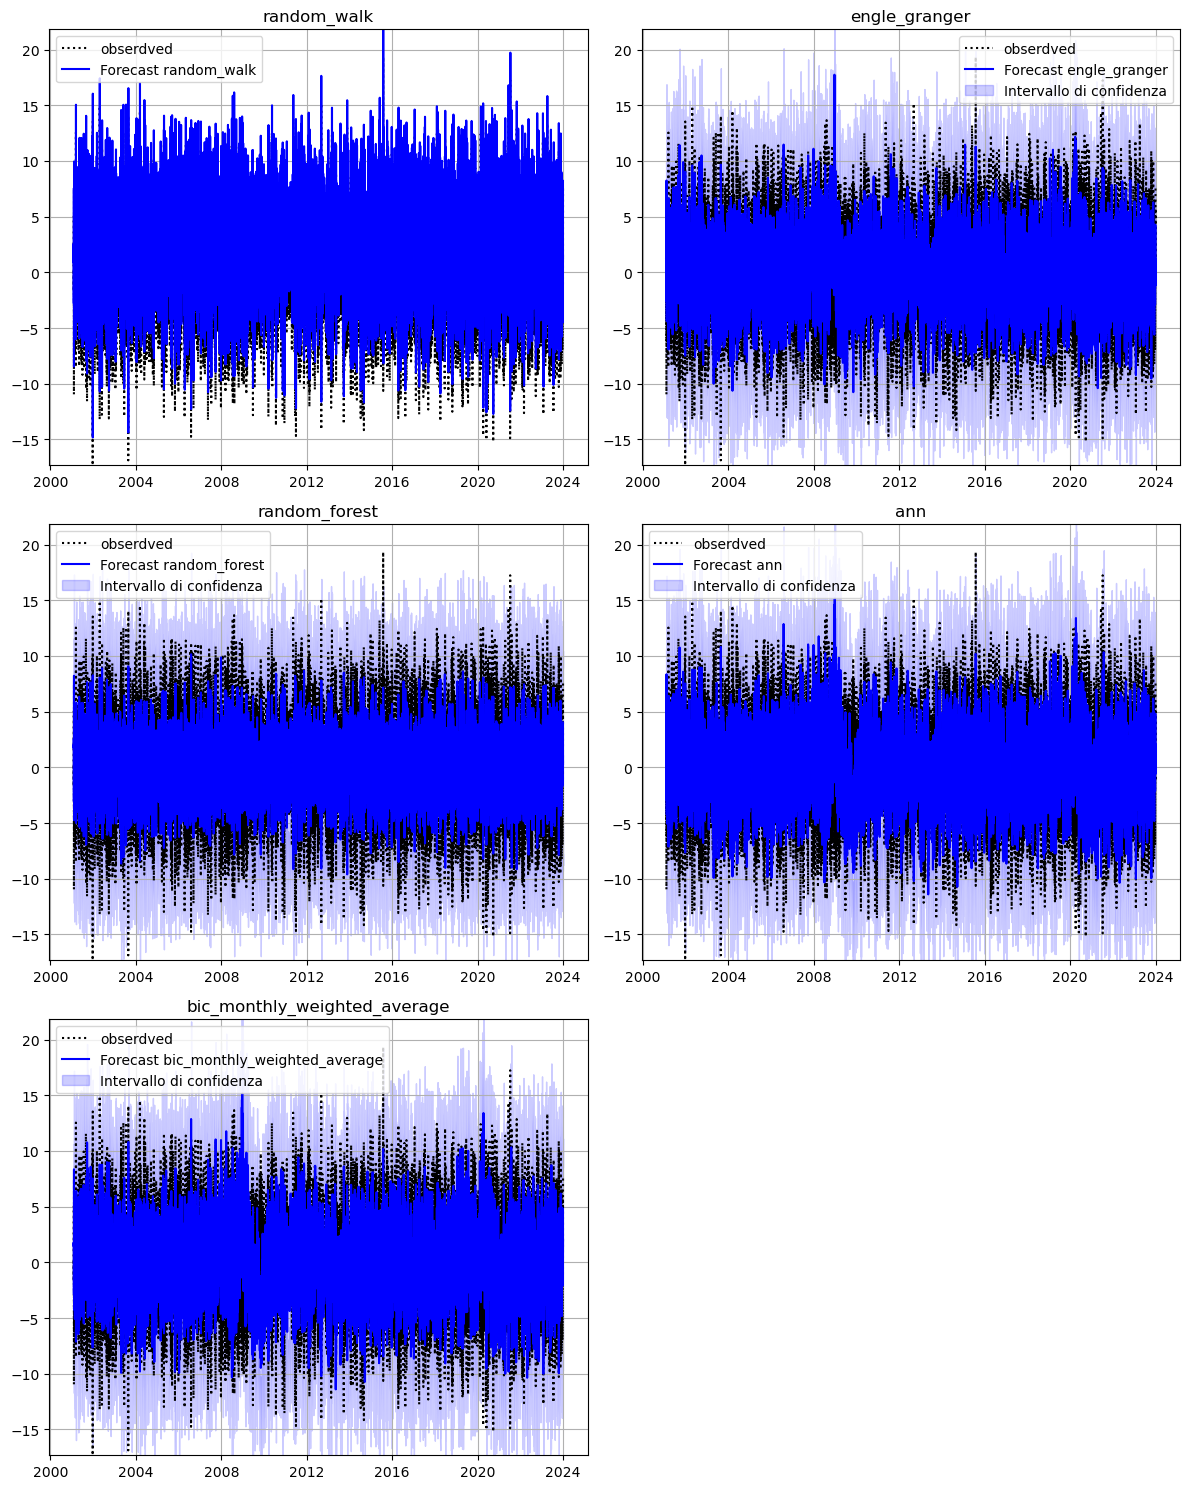

In [10]:
# Supponiamo che all_models_forecast_over_time_synthetic_data_df sia già definito
observed_returns = all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"]

# Troviamo i valori minimi e massimi per uniformare gli assi Y
y_min = min(observed_returns.min(), min(data["forecast"].min() for data in models_dict.values()))
y_max = max(observed_returns.max(), max(data["forecast"].max() for data in models_dict.values()))

# Numero di modelli
num_models = len(models_dict)

# Creiamo la griglia di sottoplot (2 colonne per riga)
num_cols = 2
num_rows = int(np.ceil(num_models / num_cols))  # Numero di righe necessario

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5 * num_rows))  # Dimensione dinamica
axes = axes.flatten()  # Rende più facile iterare sugli assi

# Ciclo sui modelli per creare i grafici
for i, (model_name, data) in enumerate(models_dict.items()):
    ax = axes[i]  # Selezioniamo l'asse corrispondente

    # Plot delle osservazioni
    ax.plot(observed_returns, label="obserdved", color='black', linestyle="dotted")

    # Plot del forecast
    ax.plot(data["forecast"], label=f"Forecast {model_name}", color='blue')

    # Se il modello ha intervalli di confidenza, li aggiungiamo
    if "lower_bound" in data and "upper_bound" in data:
        ax.fill_between(data["forecast"].index, data["lower_bound"], data["upper_bound"], 
                        color='blue', alpha=0.2, label="Intervallo di confidenza")

    ax.set_title(model_name)  # Titolo con il nome del modello
    ax.legend()  # Mostra legenda
    ax.grid(True)  # Griglia per migliore leggibilità

    # Uniformiamo l'asse Y per tutti i grafici
    ax.set_ylim(y_min, y_max)

# Rimuove eventuali assi vuoti se il numero di modelli è dispari
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Ottimizza gli spazi tra i grafici
plt.show()  # Mostra l'immagine con tutti i grafici


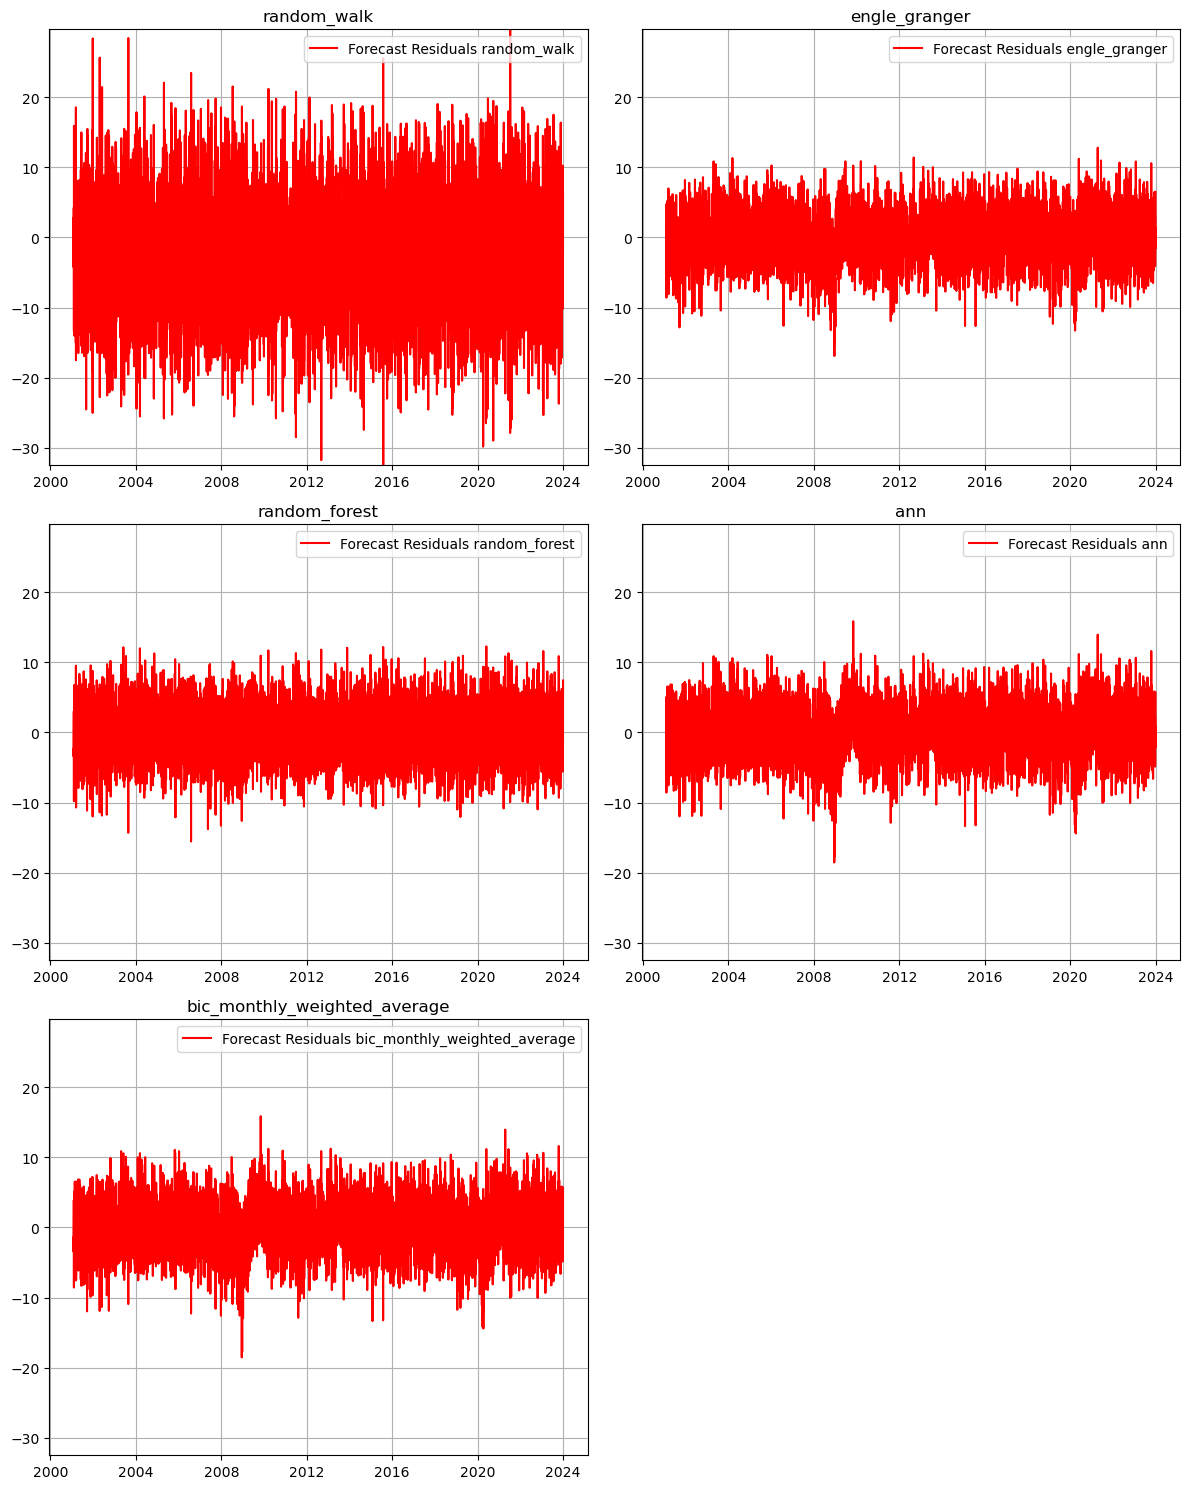

In [11]:
# Supponiamo che all_models_forecast_over_time_synthetic_data_no_svr_df sia già definito
observed_returns = all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"]

# Troviamo i limiti minimi e massimi per i forecast residuals
y_min = min(data["forecast_residuals"].min() for data in models_dict.values())
y_max = max(data["forecast_residuals"].max() for data in models_dict.values())

# Numero di modelli
num_models = len(models_dict)

# Creiamo la griglia di sottoplot (2 colonne per riga)
num_cols = 2
num_rows = int(np.ceil(num_models / num_cols))  # Numero di righe necessario

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5 * num_rows))  # Dimensione dinamica
axes = axes.flatten()  # Rende più facile iterare sugli assi

# Ciclo sui modelli per creare i grafici
for i, (model_name, data) in enumerate(models_dict.items()):

    ax = axes[i]  # Selezioniamo l'asse corrispondente

    # Plot dei forecast residuals
    ax.plot(data["forecast_residuals"], label=f"Forecast Residuals {model_name}", color='red')

    ax.set_title(model_name)  # Titolo con il nome del modello
    ax.legend()  # Mostra legenda
    ax.grid(True)  # Griglia per migliore leggibilità

    # Uniformiamo l'asse Y per tutti i grafici
    ax.set_ylim(y_min, y_max)

# Rimuove eventuali assi vuoti se il numero di modelli è dispari
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Ottimizza gli spazi tra i grafici
plt.show()  # Mostra l'immagine con tutti i grafici


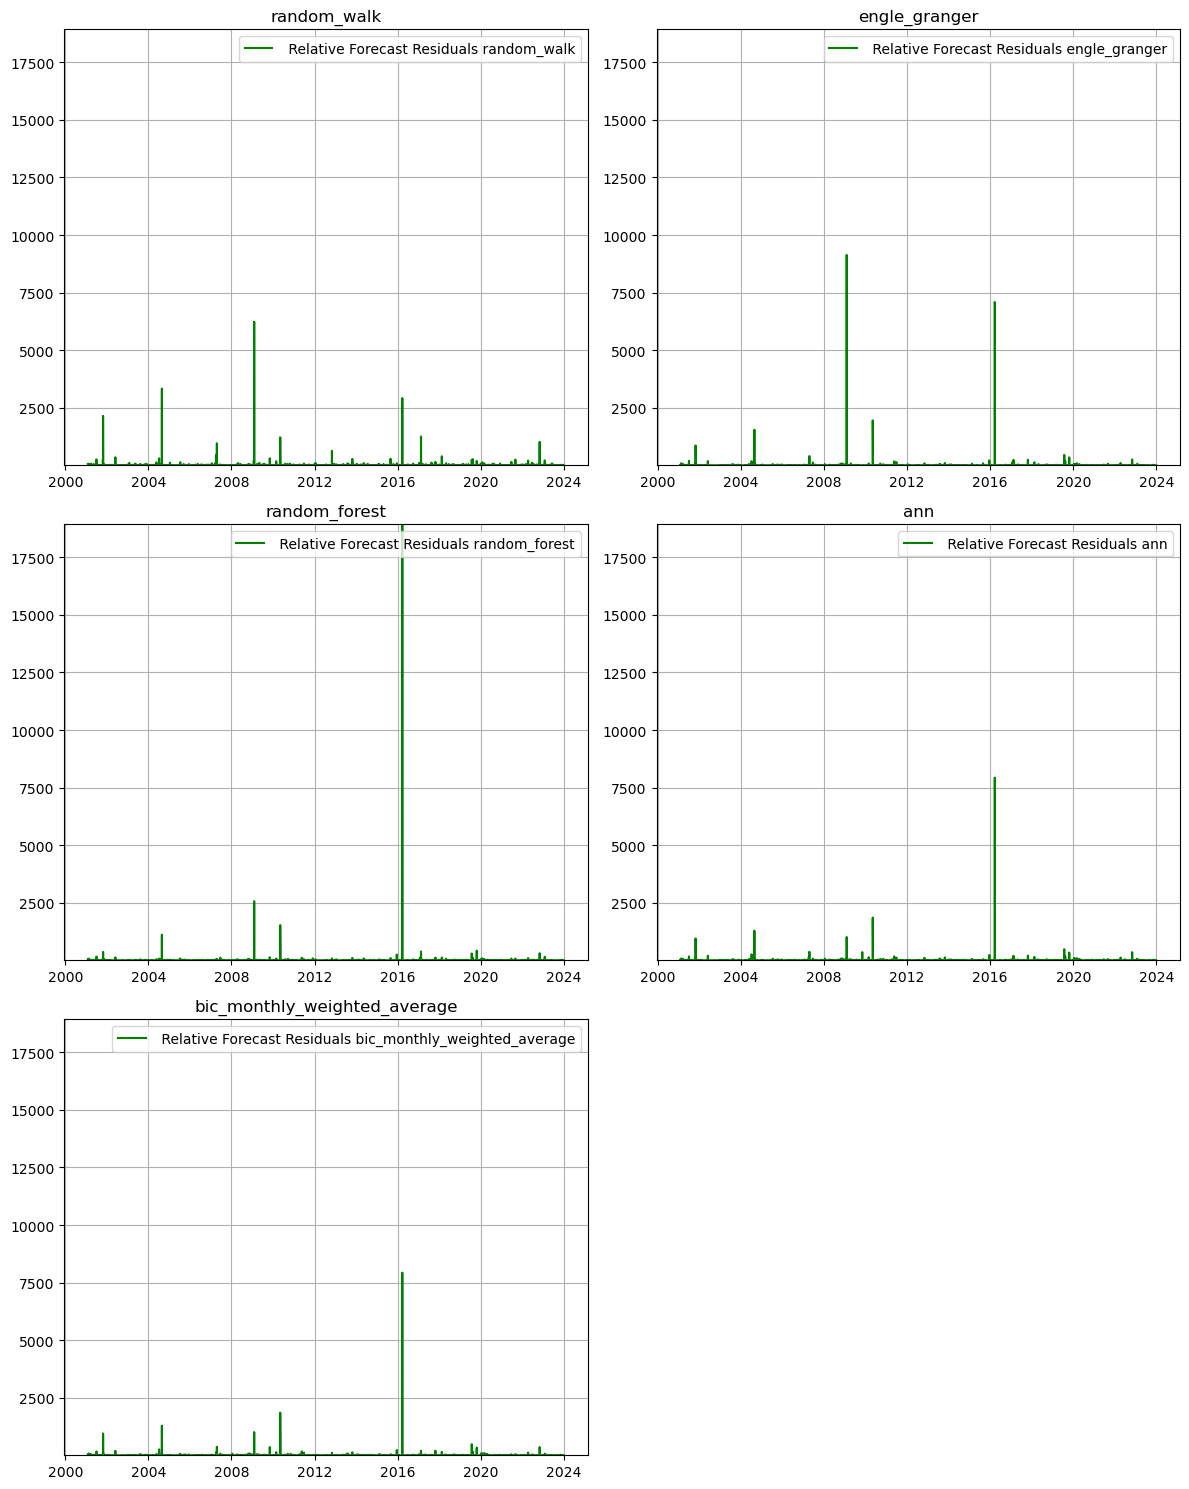

In [12]:
# Supponiamo che all_models_forecast_over_time_synthetic_data_no_svr_df sia già definito
observed_returns = all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"]

# Troviamo i limiti minimi e massimi per i forecast residuals
y_min = min(data["relative_forecast_residuals"].min() for data in models_dict.values())
y_max = max(data["relative_forecast_residuals"].max() for data in models_dict.values())

# Numero di modelli
num_models = len(models_dict)

# Creiamo la griglia di sottoplot (2 colonne per riga)
num_cols = 2
num_rows = int(np.ceil(num_models / num_cols))  # Numero di righe necessario

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5 * num_rows))  # Dimensione dinamica
axes = axes.flatten()  # Rende più facile iterare sugli assi

relative_forecast_residuals_synthetic_data_no_svr_df = pd.DataFrame()

# Ciclo sui modelli per creare i grafici
for i, (model_name, data) in enumerate(models_dict.items()):

    ax = axes[i]  # Selezioniamo l'asse corrispondente

    # Plot dei forecast residuals
    ax.plot(data["relative_forecast_residuals"], label=f" Relative Forecast Residuals {model_name}", color='g')

    ax.set_title(model_name)  # Titolo con il nome del modello
    ax.legend()  # Mostra legenda
    ax.grid(True)  # Griglia per migliore leggibilità

    # Uniformiamo l'asse Y per tutti i grafici
    ax.set_ylim(y_min, y_max)
    
    relative_forecast_residuals_synthetic_data_no_svr_df[model_name] = data["relative_forecast_residuals"]


# Rimuove eventuali assi vuoti se il numero di modelli è dispari
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Ottimizza gli spazi tra i grafici
plt.show()  # Mostra l'immagine con tutti i grafici


In [13]:
relative_forecast_residuals_synthetic_data_no_svr_df.to_csv("relative_forecast_residuals_synthetic_data_no_svr_df.csv", index=False)


In [14]:
relative_forecast_residuals_random_walk = (models_dict["random_walk"]["relative_forecast_residuals"])
print(relative_forecast_residuals_random_walk.idxmax(),relative_forecast_residuals_random_walk.max())

2009-02-03 00:00:00 6234.946659391981


In [15]:
relative_forecast_residuals_engle_granger = (models_dict["engle_granger"]["relative_forecast_residuals"])
print(relative_forecast_residuals_engle_granger.idxmax(),relative_forecast_residuals_engle_granger.max())

2009-02-03 00:00:00 9134.009247477146


In [16]:
relative_forecast_residuals_random_forest = (models_dict["random_forest"]["relative_forecast_residuals"])
print(relative_forecast_residuals_random_forest.idxmax(),relative_forecast_residuals_random_forest.max())

2016-03-22 00:00:00 18933.249137907726


In [17]:
relative_forecast_residuals_ann = (models_dict["ann"]["relative_forecast_residuals"])
print(relative_forecast_residuals_ann.idxmax(),relative_forecast_residuals_ann.max())

2016-03-22 00:00:00 7931.660602352127


In [18]:
relative_forecast_residuals_bic_monthly_weighted_average = (models_dict["bic_monthly_weighted_average"]["relative_forecast_residuals"])
print(relative_forecast_residuals_bic_monthly_weighted_average.idxmax(),relative_forecast_residuals_bic_monthly_weighted_average.max())

2016-03-22 00:00:00 7931.660602352127


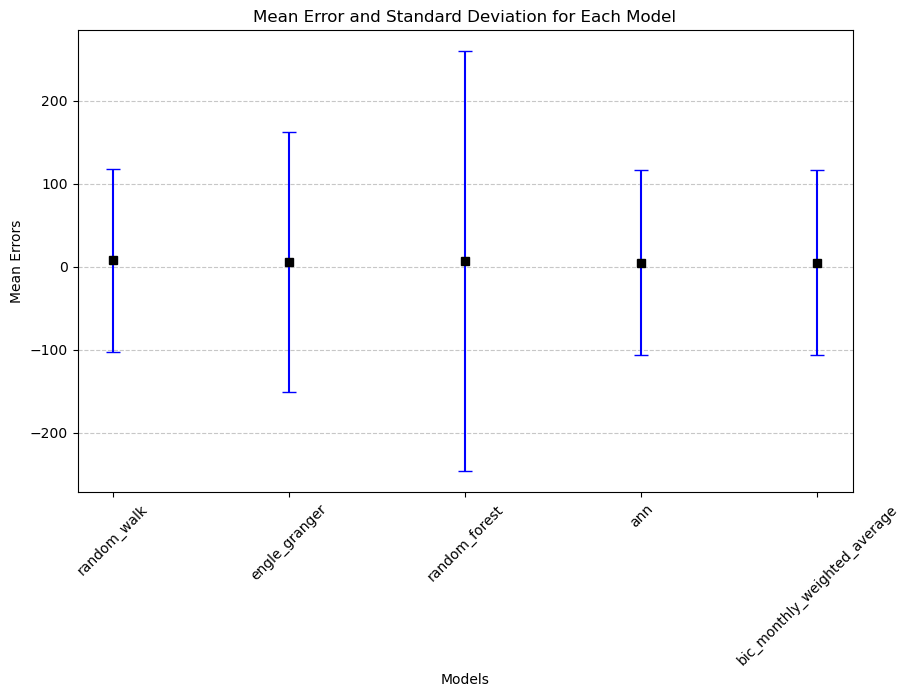

In [19]:
# Standard deviation of relative forecast residuals
results = {}

# Ciclo sui modelli
for model_name, model_data in models_dict.items():
    mean_residuals = np.mean(model_data["relative_forecast_residuals"])
    std_residuals = np.std(model_data["relative_forecast_residuals"])
    results[model_name] = (mean_residuals, std_residuals)

# Estrarre i nomi dei modelli e i valori calcolati
models = list(results.keys())
means = [results[m][0] for m in models]
std_devs = [results[m][1] for m in models]

# Creazione del grafico
plt.figure(figsize=(10, 6))
plt.errorbar(models, means, yerr=std_devs, fmt='s', capsize=5, color='black', ecolor='blue')

# Aggiungere etichette e titolo
plt.xlabel("Models")
plt.ylabel("Mean Errors")
plt.title("Mean Error and Standard Deviation for Each Model")
plt.xticks(rotation=45)  # Ruota le etichette per migliore leggibilità
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostra il grafico
plt.show()


#  Test RMSE for all models

In [76]:
rmse_dict = {}

# Identifica le colonne che contengono i forecast (escludendo intervalli di confidenza)
forecast_columns = [col for col in all_models_forecast_over_time_synthetic_data_no_svr_df.columns if col.startswith("forecast_")]

observed_sp500_returns = all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"]

# Calcola l'RMSE per ogni modello
for col in forecast_columns:
    y_pred = all_models_forecast_over_time_synthetic_data_no_svr_df[col]  # Valori previsti
    rmse = np.sqrt(np.mean((observed_sp500_returns - y_pred) ** 2))  # RMSE formula
    rmse_dict[col] = rmse  # Salva nel dizionario

rmse_dict

{'forecast_randomwalk': 8.766723832114188,
 'forecast_engle_granger': 3.8331942046414635,
 'forecast_rf': 3.968410441566538,
 'forecast_ann': 3.952243380247982,
 'forecast_ensemble_learning_simple_mean': 3.8032804219823513,
 'forecast_ensemble_learning_weighted_r2': 3.812623617480043,
 'forecast_ensemble_learning_weighted_rmse': 3.802856274045023,
 'forecast_ensemble_learning_weighted_test_rmse': 3.802637883773065,
 'forecast_bic_monthly_best': 3.952243380247982,
 'forecast_aic_monthly_best': 3.952243380247982,
 'forecast_bic_monthly_weighted_average': 3.952243380247982,
 'forecast_aic_monthly_weighted_average': 3.952243380247982,
 'forecast_bic_monthly_weighted_average_converted': 2256.531064409611}

## Metrics Table

In [77]:
# Creazione del DataFrame
rmse_df = pd.DataFrame(list(rmse_dict.items()), columns=["Model", "RMSE"] )
# Imposta la colonna "Model" come indice
rmse_df.set_index("Model", inplace=True)
print(tabulate(rmse_df, headers="keys", tablefmt="plain", stralign="left"))

Model                                                  RMSE
forecast_randomwalk                                 8.76672
forecast_engle_granger                              3.83319
forecast_rf                                         3.96841
forecast_ann                                        3.95224
forecast_ensemble_learning_simple_mean              3.80328
forecast_ensemble_learning_weighted_r2              3.81262
forecast_ensemble_learning_weighted_rmse            3.80286
forecast_ensemble_learning_weighted_test_rmse       3.80264
forecast_bic_monthly_best                           3.95224
forecast_aic_monthly_best                           3.95224
forecast_bic_monthly_weighted_average               3.95224
forecast_aic_monthly_weighted_average               3.95224
forecast_bic_monthly_weighted_average_converted  2256.53


# T-test

In [78]:
# Supponiamo che questi siano i tuoi errori calcolati (sostituiscili con i tuoi dati reali)
errors_dict = {
    "random_walk": models_dict["random_walk"]["forecast_residuals"],
    "engle_granger": models_dict["engle_granger"]["forecast_residuals"],
    "Random_forest": models_dict["random_forest"]["forecast_residuals"],
    "ann": models_dict["ann"]["forecast_residuals"],
    "bic_monthly_weighted_average": models_dict["bic_monthly_weighted_average"]["forecast_residuals"],
    }


# Generiamo tutte le coppie possibili di modelli
model_pairs = list(itertools.combinations(errors_dict.keys(), 2))

# Eseguiamo il test t per ogni coppia
t_test_results = []
for model1, model2 in model_pairs:
    t_stat, p_value = ttest_rel(errors_dict[model1], errors_dict[model2])
    t_test_results.append((model1, model2, t_stat, p_value))



In [79]:
# Creiamo una matrice quadrata inizializzata con NaN
p_value_matrix_forecast_residuals = pd.DataFrame(np.nan, index = errors_dict.keys(), columns = errors_dict.keys())

# Inseriamo i p-value nei punti corretti della matrice (simmetrica)
for model1, model2, t_stat, p_value in t_test_results:
    p_value_matrix_forecast_residuals.loc[model1, model2] = round(p_value, 4)
    p_value_matrix_forecast_residuals.loc[model2, model1] = round(p_value, 4)  # Simmetria

p_value_matrix_forecast_residuals


,random_walk,engle_granger,Random_forest,ann,bic_monthly_weighted_average
random_walk,NaN,0.0000,0.0000,0.0000,0.0000
engle_granger,0.0,NaN,0.0005,0.0000,0.0000
Random_forest,0.0,0.0005,NaN,0.8606,0.8606
ann,0.0,0.0000,0.8606,NaN,NaN
bic_monthly_weighted_average,0.0,0.0000,0.8606,NaN,NaN


In [80]:
# Errori relativi

relative_errors_dict = {
    "random_walk": models_dict["random_walk"]["relative_forecast_residuals"],
    "engle_granger": models_dict["engle_granger"]["relative_forecast_residuals"],
    "Random_forest": models_dict["random_forest"]["relative_forecast_residuals"],
    "ann": models_dict["ann"]["relative_forecast_residuals"],
    "bic_monthly_weighted_average": models_dict["bic_monthly_weighted_average"]["relative_forecast_residuals"],
    }


# Generiamo tutte le coppie possibili di modelli
model_pairs = list(itertools.combinations(relative_errors_dict.keys(), 2))

# Eseguiamo il test t per ogni coppia
t_test_results_relative_residuals = []
for model1, model2 in model_pairs:
    t_stat, p_value = ttest_rel(relative_errors_dict[model1], relative_errors_dict[model2])
    t_test_results_relative_residuals.append((model1, model2, t_stat, p_value))



In [81]:
# Creiamo una matrice quadrata inizializzata con NaN
p_value_matrix_forecast_relative_residuals = pd.DataFrame(np.nan, index = relative_errors_dict.keys(), columns = relative_errors_dict.keys())

# Inseriamo i p-value nei punti corretti della matrice (simmetrica)
for model1, model2, t_stat, p_value in t_test_results_relative_residuals:
    p_value_matrix_forecast_relative_residuals.loc[model1, model2] = round(p_value, 4)
    p_value_matrix_forecast_relative_residuals.loc[model2, model1] = round(p_value, 4)  # Simmetria

p_value_matrix_forecast_relative_residuals


,random_walk,engle_granger,Random_forest,ann,bic_monthly_weighted_average
random_walk,NaN,0.0680,0.6323,0.0282,0.0282
engle_granger,0.0680,NaN,0.8434,0.4271,0.4271
Random_forest,0.6323,0.8434,NaN,0.4103,0.4103
ann,0.0282,0.4271,0.4103,NaN,NaN
bic_monthly_weighted_average,0.0282,0.4271,0.4103,NaN,NaN


## Weights Table

In [82]:
'''
# Creation of the statistics dictionary for BIC weights
stat_dict_bic = {
    'Engle Granger BIC': {
        'Mean': np.mean(weight_bic_engle_granger_list),
        'Std Dev': np.std(weight_bic_engle_granger_list),
        'Min': np.min(weight_bic_engle_granger_list),
        'Max': np.max(weight_bic_engle_granger_list),
    },
    'Random Forest BIC': {
        'Mean': np.mean(weight_bic_rf_list),
        'Std Dev': np.std(weight_bic_rf_list),
        'Min': np.min(weight_bic_rf_list),
        'Max': np.max(weight_bic_rf_list),
    },
    'SVR BIC': {
        'Mean': np.mean(weight_bic_svr_list),
        'Std Dev': np.std(weight_bic_svr_list),
        'Min': np.min(weight_bic_svr_list),
        'Max': np.max(weight_bic_svr_list),
    },
    'ANN BIC': {
        'Mean': np.mean(weight_bic_ann_list),
        'Std Dev': np.std(weight_bic_ann_list),
        'Min': np.min(weight_bic_ann_list),
        'Max': np.max(weight_bic_ann_list),
    }
}

# Creation of the statistics dictionary for AIC weights
stat_dict_aic = {
    'Engle Granger AIC': {
        'Mean': np.mean(weight_aic_engle_granger_list),
        'Std Dev': np.std(weight_aic_engle_granger_list),
        'Min': np.min(weight_aic_engle_granger_list),
        'Max': np.max(weight_aic_engle_granger_list),
    },
    'Random Forest AIC': {
        'Mean': np.mean(weight_aic_rf_list),
        'Std Dev': np.std(weight_aic_rf_list),
        'Min': np.min(weight_aic_rf_list),
        'Max': np.max(weight_aic_rf_list),
    },
    'SVR AIC': {
        'Mean': np.mean(weight_aic_svr_list),
        'Std Dev': np.std(weight_aic_svr_list),
        'Min': np.min(weight_aic_svr_list),
        'Max': np.max(weight_aic_svr_list),
    },
    'ANN AIC': {
        'Mean': np.mean(weight_aic_ann_list),
        'Std Dev': np.std(weight_aic_ann_list),
        'Min': np.min(weight_aic_ann_list),
        'Max': np.max(weight_aic_ann_list),
    }
}

# Creation of DataFrames from the statistics dictionaries
stat_df_bic = pd.DataFrame(stat_dict_bic).T  # Transpose to have models as rows and statistics as columns
stat_df_aic = pd.DataFrame(stat_dict_aic).T
stat_df = pd.concat([stat_df_bic, stat_df_aic], axis=0)
print(stat_df)
'''

"\n# Creation of the statistics dictionary for BIC weights\nstat_dict_bic = {\n    'Engle Granger BIC': {\n        'Mean': np.mean(weight_bic_engle_granger_list),\n        'Std Dev': np.std(weight_bic_engle_granger_list),\n        'Min': np.min(weight_bic_engle_granger_list),\n        'Max': np.max(weight_bic_engle_granger_list),\n    },\n    'Random Forest BIC': {\n        'Mean': np.mean(weight_bic_rf_list),\n        'Std Dev': np.std(weight_bic_rf_list),\n        'Min': np.min(weight_bic_rf_list),\n        'Max': np.max(weight_bic_rf_list),\n    },\n    'SVR BIC': {\n        'Mean': np.mean(weight_bic_svr_list),\n        'Std Dev': np.std(weight_bic_svr_list),\n        'Min': np.min(weight_bic_svr_list),\n        'Max': np.max(weight_bic_svr_list),\n    },\n    'ANN BIC': {\n        'Mean': np.mean(weight_bic_ann_list),\n        'Std Dev': np.std(weight_bic_ann_list),\n        'Min': np.min(weight_bic_ann_list),\n        'Max': np.max(weight_bic_ann_list),\n    }\n}\n\n# Creation of

# Weights plots

In [83]:
models_weights_over_time_synthetic_data_no_svr_df.head()

,ann,return_sp_500
2001-02-01,1.0,0.065081
2001-02-02,1.0,-1.673084
2001-02-05,1.0,5.058399
2001-02-06,1.0,-0.108983
2001-02-07,1.0,-10.951482


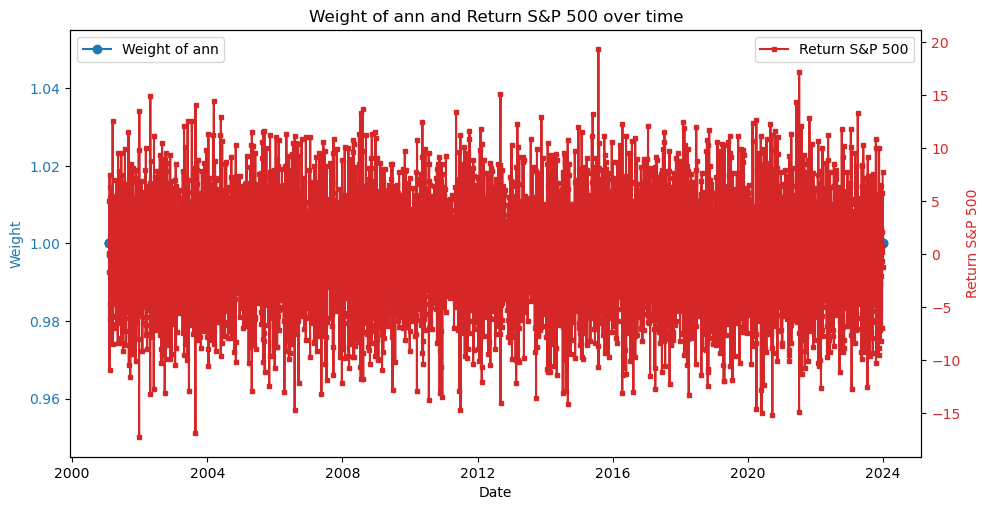

In [23]:
# Creiamo i grafici
for model_name in models_weights_over_time_synthetic_data_no_svr_df.columns[:-1]:  # Escludiamo la colonna 'return_sp_500'
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Weight', color='tab:blue')
    ax1.plot(models_weights_over_time_synthetic_data_no_svr_df.index, models_weights_over_time_synthetic_data_no_svr_df[model_name], marker='o',  color='tab:blue', label=f'Weight of {model_name}')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Return S&P 500', color='tab:red')
    ax2.plot(models_weights_over_time_synthetic_data_no_svr_df.index, models_weights_over_time_synthetic_data_no_svr_df['return_sp_500'], marker='s', linestyle = None, markersize =3,  color='tab:red', label='Return S&P 500')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.legend(loc='upper right')
    
    fig.tight_layout()
    plt.title(f'Weight of {model_name} and Return S&P 500 over time')
    plt.savefig(f'plots/Weight_of_{model_name}_and_Return_S&P_500_over_time.svg', format='svg')

    plt.show()

## P-Values ADF TEST

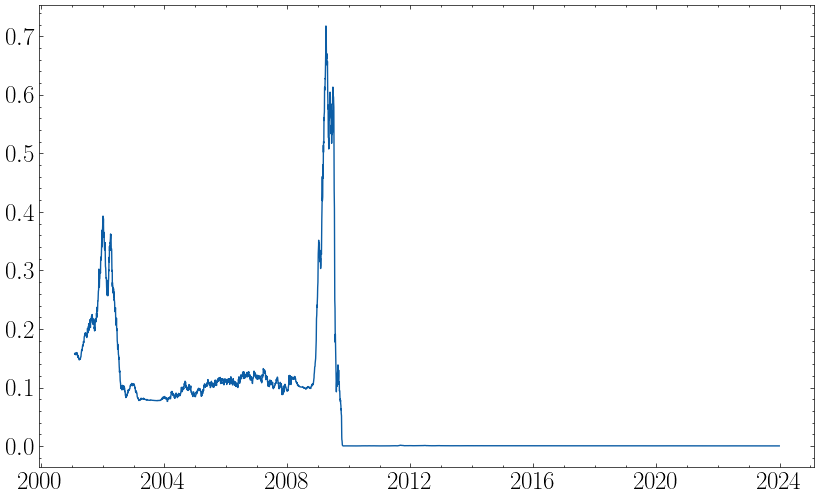

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(date_list, adf_output_list, label='ADF Test for residuals_Step1')
plt.xticks(fontsize=18)  
plt.yticks(fontsize=18)
plt.grid(False)
#plt.savefig('grafici/ADF_Test_for_residuals_Step1.svg', format='svg')

plt.show()

## Coefficients of eps(t-1)

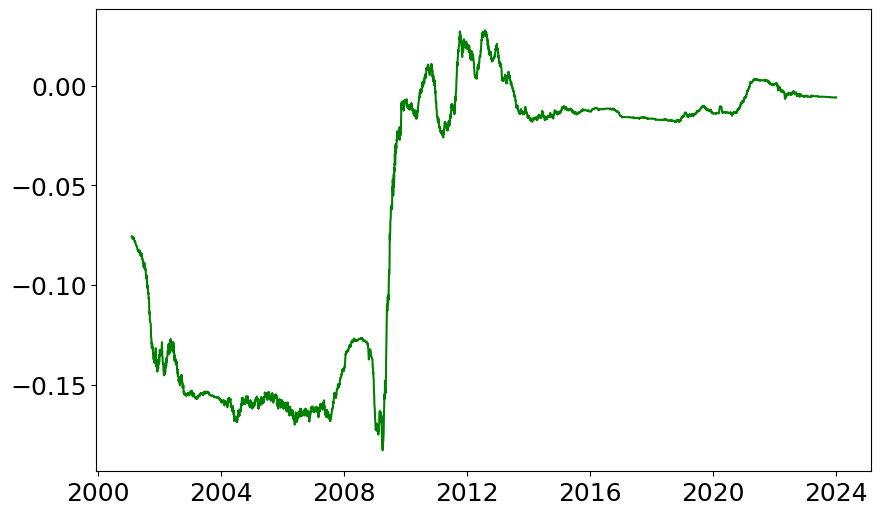

In [201]:

plt.figure(figsize=(10, 6))
plt.plot(date_list, coefficients_of_eps_t_1__step2_list, label='Coefficients of eps(t-1)', color='green')
plt.xticks(fontsize=18)  
plt.yticks(fontsize=18)
plt.grid(False)
#plt.savefig('grafici/Coefficients_of_eps(t-1).svg', format='svg')

plt.show()

## Rsquared_Step2

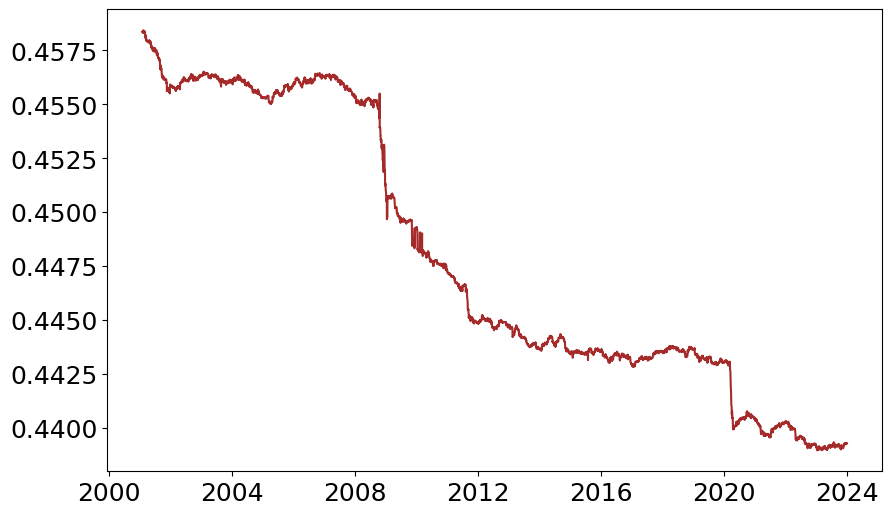

In [202]:
plt.figure(figsize=(10, 6))
plt.plot(date_list, rsquared_step2_list, label='Rsquared Step2', color='brown')
plt.xticks(fontsize=18)  
plt.yticks(fontsize=18)
plt.grid(False)
#plt.savefig('grafici/Rsquared_Step2.svg', format='svg')

plt.show()

# Hit Ratio

In [197]:
all_models_forecast_over_time_synthetic_data_no_svr_df.head()

,observed_sp500_returns,forecast_randomwalk,forecast_engle_granger,lower_bound_engle_granger,upper_bound_engle_granger,forecast_rf,lower_bound_rf,upper_bound_rf,forecast_ann,lower_bound_ann,...,upper_bound_bic_weighted_average,forecast_aic_monthly_weighted_average,lower_bound_aic_monthly_weighted_average,upper_bound_aic_monthly_weighted_average,forecast_bic_monthly_weighted_average_converted,lower_bound_bic_weighted_average_converted,upper_bound_bic_weighted_average_converted,adf_output,rsquared_step2,coefficients_of_eps_t_1__step2
2001-02-01,0.065081,-2.717320,1.206924,-7.436898,9.850746,2.474166,-6.617069,11.565400,1.501398,-7.339180,...,10.341976,1.501398,-7.339180,10.341976,1341.982773,1223.343739,1460.621806,0.157426,0.458360,-0.075676
2001-02-02,-1.673084,2.565117,1.132390,-7.511158,9.775938,1.729827,-7.361090,10.820743,1.784897,-7.053576,...,10.623370,1.784897,-7.053576,10.623370,1346.668818,1227.643857,1465.693780,0.157461,0.458357,-0.075772
2001-02-05,5.058399,0.826875,2.637251,-6.006167,11.280670,2.046671,-7.044391,11.137733,1.172374,-7.663680,...,10.008429,1.172374,-7.663680,10.008429,1316.238356,1199.934813,1432.541900,0.156969,0.458339,-0.075934
2001-02-06,-0.108983,7.558357,-2.553330,-11.196574,6.089915,-3.071525,-12.162623,6.019573,-2.881974,-11.717859,...,5.953910,-2.881974,-11.717859,5.953910,1329.520612,1212.045710,1446.995513,0.158181,0.458361,-0.075770
2001-02-07,-10.951482,2.390889,-2.372198,-11.015272,6.270875,-1.160595,-10.251466,7.930276,-2.384071,-11.230129,...,6.461987,-2.384071,-11.230129,6.461987,1334.701462,1216.633000,1452.769923,0.159042,0.458345,-0.075605


In [198]:
def binarize_returns(returns):
    
    binarized_returns_list = []
    
    for value in returns:
        
        if value >= 0:
            
            value = 1
            
        else:
            
            value = 0
            
        binarized_returns_list.append(value)
        
    returns = pd.Series(binarized_returns_list, index=returns.index)
     
    return returns       

In [204]:
observed_sp500_returns = all_models_forecast_over_time_synthetic_data_no_svr_df["observed_sp500_returns"]
observed_sp500_returns.head(10)

2001-02-01     0.065081
2001-02-02    -1.673084
2001-02-05     5.058399
2001-02-06    -0.108983
2001-02-07   -10.951482
2001-02-08     7.455684
2001-02-09     5.306734
2001-02-12    -6.169559
2001-02-13     1.606916
2001-02-14    -4.680079
Name: observed_sp500_returns, dtype: float64

In [205]:
binarize_returns (observed_sp500_returns).head(10)

2001-02-01    1
2001-02-02    0
2001-02-05    1
2001-02-06    0
2001-02-07    0
2001-02-08    1
2001-02-09    1
2001-02-12    0
2001-02-13    1
2001-02-14    0
dtype: int64

In [206]:
# Binarized Dataframe creation
for colonna in all_models_forecast_over_time_synthetic_data_no_svr_df.columns:
    
    if colonna == "observed_sp500_returns":
        binarized_observed_sp500_returns = binarize_returns(all_models_forecast_over_time_synthetic_data_no_svr_df[colonna])
        df_binarized = pd.DataFrame(index=all_models_forecast_over_time_synthetic_data_no_svr_df.index)
        df_binarized[colonna] = binarized_observed_sp500_returns
    
    elif colonna.startswith("forecast_"):
        binarized_forecast = binarize_returns(all_models_forecast_over_time_synthetic_data_no_svr_df[colonna])
        df_binarized[colonna] = binarized_forecast
  
df_binarized.head(10)  
    
hit_ratio_df = pd.DataFrame(columns = ["hit_ratio_percent"] , index = df_binarized.columns[1:])


    
df_binarized.head()

,observed_sp500_returns,forecast_randomwalk,forecast_engle_granger,forecast_rf,forecast_ann,forecast_ensemble_learning_simple_mean,forecast_ensemble_learning_weighted_r2,forecast_ensemble_learning_weighted_rmse,forecast_ensemble_learning_weighted_test_rmse,forecast_bic_monthly_best,forecast_aic_monthly_best,forecast_bic_monthly_weighted_average,forecast_aic_monthly_weighted_average,forecast_bic_monthly_weighted_average_converted
2001-02-01,1,0,1,1,1,1,1,1,1,1,1,1,1,1
2001-02-02,0,1,1,1,1,1,1,1,1,1,1,1,1,1
2001-02-05,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2001-02-06,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2001-02-07,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [207]:
for column in df_binarized.columns:
    
    if column == "observed_sp500_returns":
        continue
    
    comparison = df_binarized[column] == df_binarized["observed_sp500_returns"]
    num_hit_ratio = 0
    
    for value in comparison:
        if value == True:
            num_hit_ratio += 1
            
    hit_ratio = num_hit_ratio / len(comparison) * 100
    hit_ratio_df.loc[column] = hit_ratio

In [208]:
hit_ratio_df

,hit_ratio_percent
forecast_randomwalk,35.357391
forecast_engle_granger,72.58848
forecast_rf,69.552394
forecast_ann,71.634282
forecast_ensemble_learning_simple_mean,72.276197
forecast_ensemble_learning_weighted_r2,72.501735
forecast_ensemble_learning_weighted_rmse,72.310895
forecast_ensemble_learning_weighted_test_rmse,72.328244
forecast_bic_monthly_best,71.634282
forecast_aic_monthly_best,71.634282
